# CONTENT

[CONFIGURATION](#configuration) 

[MAIN FUNCTION](#main_function)

[MODEL](#model)

[EXECUTION](#execution)

# **LIBRARIES**

In [18]:
import os
import tempfile
import gc
import time
import numpy as np
import pandas as pd
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from glob import glob
from pathlib import Path
from datetime import datetime
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve, auc
import sklearn
from sklearn.feature_selection import SelectKBest, f_classif
from tqdm.notebook import tqdm
import joblib
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)




import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



# **CONFIGURATION**
<a id='configuration'></a>

[CONFIGURATION](#configuration) 

[MAIN FUNCTION](#main_function)

[MODEL](#model)

[EXECUTION](#execution)

In [19]:
# GENERAL CONFIGURATIONS
NUM_THREADS = 4
DATA_DIRECTORY = "/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/"
SUBMISSION_SUFIX = "_model_2.1_31"
#MODE CONFIGURATION
SHOW_REPORT = False
SELECTKBEST = False
EXPORT_DATAFRAME = False
IMPORT_DATAFRAME = True
# LIGHTGBM CONFIGURATION AND HYPER-PARAMETERS
GENERATE_SUBMISSION_FILES = True
EVALUATE_VALIDATION_SET = True
STRATIFIED_KFOLD = True
BALANCE_COLUMNS = False
RANDOM_SEED = 324
NUM_FOLDS = 2
EARLY_STOPPING = 100
ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")



### Set aggregations

In [20]:
# AGGREGATIONS

# D: max, min, mean
# M: 
# A : max, min, mean, sum
# L : max, min, mean, sum


APPLPREV1_AGG = {

    'num_group1':['count'],
    'actualdpd_943P': ['min','max','mean','sum'],
    'annuity_853A': ['min','max','mean','sum'],
    'approvaldate_319D':['max','min','mean'],
    'byoccupationinc_3656910L': ['min','max','mean','sum'],
    'cancelreason_3545846M':['max'],
    'childnum_21L': ['min','max','mean','sum'],
    'creationdate_885D':['min','max','mean'],
    'credacc_actualbalance_314A': ['min','max','mean','sum'],
    'credacc_credlmt_575A': ['min','max','mean','sum'],
    'credacc_maxhisbal_375A': ['min','max','mean','sum'],
    'credacc_minhisbal_90A': ['min','max','mean','sum'],
    'credacc_status_367L': ['max'],
    'credacc_transactions_402L': ['min','max','mean','sum'],
    'credamount_590A': ['min','max','mean','sum'],
    'credtype_587L': ['max'],
    'currdebt_94A': ['min','max','mean','sum'],
    'dateactivated_425D':['min','max','mean'],
    'district_544M':['max'],
    'downpmt_134A': ['min','max','mean','sum'],
    'dtlastpmt_581D':['min','max','mean'],
    'dtlastpmtallstes_3545839D':['min','max','mean'],
    'education_1138M':['max'],
    'employedfrom_700D':['min','max','mean'],
    'familystate_726L': ['max'],
    'firstnonzeroinstldate_307D': ['min','max','mean'],
    'inittransactioncode_279L': ['max'],
    'isbidproduct_390L': ['min','max','mean','sum'],
    'isdebitcard_527L': ['min','max','mean','sum'],
    'mainoccupationinc_437A': ['min','max','mean','sum','median'],
    'maxdpdtolerance_577P': ['min','max','mean','sum'],
    'outstandingdebt_522A': ['min','max','mean','sum'],
    'pmtnum_8L': ['min','max','mean','sum'],
    'postype_4733339M':['max'],
    #'profession_152M':['max'],
    'rejectreason_755M':['max'],
    'rejectreasonclient_4145042M':['max'],
    'revolvingaccount_394A': ['min','max','mean','sum'],
    'status_219L': ['max'],
    'tenor_203L': ['min','max','mean','sum'],
    
}
APPLPREV2_AGG = {
    'num_group1':['count'],
    'num_group2':['count'],
    'conts_type_509L':['max'],
    #'cacccardblochreas_147M'
    'credacc_cards_status_52L':['max']
    
}
PERSON1_AGG={
    'num_group1':['count'],
    'birth_259D': ['max'],
    #'childnum_185L':['max','mean','min'],
    'contaddr_district_15M':['max'],
    'contaddr_matchlist_1032L':['max'],
    'contaddr_smempladdr_334L':['max'],
    'contaddr_zipcode_807M':['max'],
    'education_927M':['max'],
    'empl_employedfrom_271D':['max','mean','min'],
    'empl_employedtotal_800L':['max'],
    'empl_industry_691L':['max'],
    #'empladdr_district_926M'
    #'empladdr_zipcode_114M'
    'familystate_447L':['max','count'],
    #'gender_992L'
    'housetype_905L':['max'],
    #'housingtype_772L'
    'incometype_1044T':['max'],
    #'isreference_387L'
    'language1_981M':['max'],
    'mainoccupationinc_384A':['max','mean','min', 'count'],
    #'maritalst_703L'
    'personindex_1023L':['max','mean','min', 'count','sum'],
    'persontype_1072L':['max','mean','min', 'count','sum'],
    'persontype_792L':['max','mean','min', 'count','sum'],
    #'registaddr_district_1083M'
    #'registaddr_zipcode_184M'
    'relationshiptoclient_415T':['max','count'],
    'relationshiptoclient_642T':['max','count'],
    'remitter_829L':['max'],
    'role_1084L':['max','count'],
    #'role_993L'
    'safeguarantyflag_411L':['max'],
    'sex_738L':['max'],
    'type_25L':['max']
    

    
    
    
}
PERSON2_AGG={
    'num_group1':['count'],
    'num_group2':['count'],
    #'addres_district_368M'
    #'addres_role_871L'
    #'addres_zip_823M'
    #'conts_role_79M'
    'empls_economicalst_849M':['max'],
    #'empls_employedfrom_796D'
    #'empls_employer_name_740M'
    #'relatedpersons_role_762T'
}
OTHER_AGG={
    'num_group1':['count'],
    'amtdebitincoming_4809443A':['max','mean','min', 'count','sum'],
    'amtdebitoutgoing_4809440A':['max','mean','min', 'count','sum'],
    #'amtdepositbalance_4809441A'
    #'amtdepositincoming_4809444A'
    #'amtdepositoutgoing_4809442A'
}
DEBITCARD_AGG={
    'num_group1':['count'],
    #'last180dayaveragebalance_704A'
    #'last180dayturnover_1134A'
    #'last30dayturnover_651A'
    'openingdate_857D':['min','max','mean']
}
TAX_REGISTRY_A_AGG={
    'num_group1':['count'],
    'amount_4527230A': ['max','mean','min','sum'],
    'name_4527232M':['max'],
    'recorddate_4527225D':['max','mean','min']
    
}
TAX_REGISTRY_B_AGG={
    'num_group1':['count'],
    'amount_4917619A':['min','mean','max','sum'],
    'deductiondate_4917603D':['max','mean','min'],
    'name_4917606M':['max'],
    
    
}
TAX_REGISTRY_C_AGG={
    'num_group1':['count'],
    'employername_160M':['max'],
    'pmtamount_36A':['min','mean','max','sum'],
    'processingdate_168D':['mean','min','max'],

}
CREDIT_BUREAU_A_1_AGG={
    
    'num_group1':['count'],
    #'annualeffectiverate_199L'
    #'annualeffectiverate_63L'
    'classificationofcontr_13M':['max'],
    'classificationofcontr_400M':['max'],
    'contractst_545M':['max'],
    'contractst_964M':['max'],
    #'contractsum_5085717L'
    #'credlmt_230A'
    'credlmt_935A':['max'],
    'dateofcredend_289D':['mean','min','max'],
    'dateofcredend_353D':['mean','min','max'],
    'dateofcredstart_181D':['mean','min','max'],
    'dateofcredstart_739D':['mean','min','max'],
    'dateofrealrepmt_138D':['mean','min','max'],
    'debtoutstand_525A':['min','mean','max','sum'],
    'debtoverdue_47A':['min','mean','max','sum'],
    'description_351M':['max'],
    'dpdmax_139P':['min','mean','max','sum'],
    #'dpdmax_757P'
    #'dpdmaxdatemonth_442T':['max'],
    #'dpdmaxdatemonth_89T':['max'],
    #'dpdmaxdateyear_596T'
    #'dpdmaxdateyear_896T'
    'financialinstitution_382M':['max'],
    'financialinstitution_591M':['max'],
    'instlamount_768A':['min','mean','max','sum'],
    #'instlamount_852A'
    #'interestrate_508L'
    'lastupdate_1112D':['mean','min','max'],
    'lastupdate_388D':['mean','min','max'],
    'monthlyinstlamount_332A':['min','mean','max','sum'],
    #'monthlyinstlamount_674A'
    'nominalrate_281L':['mean','min','max'],
    #'nominalrate_498L'
    'numberofcontrsvalue_258L':['min','mean','max','sum'],
    'numberofcontrsvalue_358L':['min','mean','max','sum'],
    #'numberofinstls_229L':
    'numberofinstls_320L':['min','mean','max','sum'],
    #'numberofoutstandinstls_520L'
    'numberofoutstandinstls_59L':['min','mean','max','sum'],
    'numberofoverdueinstlmax_1039L':['min','mean','max','sum'],
    #'numberofoverdueinstlmax_1151L'
    #'numberofoverdueinstlmaxdat_148D'
    'numberofoverdueinstlmaxdat_641D':['mean','min','max'],
    
    
      
    'overdueamountmaxdatemonth_284T': ['min', 'mean', 'max'],
    'overdueamountmaxdatemonth_365T': ['min', 'mean', 'max'],
    'overdueamountmaxdateyear_2T': ['min', 'mean', 'max'],
    'overdueamountmaxdateyear_994T': ['min', 'mean', 'max'],
    'periodicityofpmts_1102L': ['min', 'mean', 'max'],
    'periodicityofpmts_837L': ['min', 'mean', 'max'],
    'prolongationcount_1120L': ['min', 'mean', 'max'],
    'prolongationcount_599L': ['min', 'mean', 'max'],
    'purposeofcred_426M': ['min', 'mean', 'max'],
    'purposeofcred_874M': ['min', 'mean', 'max'],
    'refreshdate_3813885D': ['min', 'mean', 'max'],
    'residualamount_488A': ['min', 'mean', 'max'],
    'residualamount_856A': ['min', 'mean', 'max'],
   
    'totalamount_6A': ['min', 'mean', 'max'],
    'totalamount_996A': ['min', 'mean', 'max'],
    'totaldebtoverduevalue_178A': ['min', 'mean', 'max'],
    'totaldebtoverduevalue_718A': ['min', 'mean', 'max'],
    'totaloutstanddebtvalue_39A': ['min', 'mean', 'max'],
    'totaloutstanddebtvalue_668A': ['min', 'mean', 'max']
   
}
CREDIT_BUREAU_B_1_AGG={
    'num_group1':['count'],
    
}
CREDIT_BUREAU_A_2_AGG={
 
   
    'pmts_dpd_1073P': ['min', 'mean', 'max'],
    'pmts_dpd_303P': ['min', 'mean', 'max'],
    'pmts_month_158T': ['min', 'mean', 'max'],
    'pmts_month_706T': ['min', 'mean', 'max'],
    'pmts_overdue_1140A': ['min', 'mean', 'max'],
    'pmts_overdue_1152A': ['min', 'mean', 'max'],
    'pmts_year_1139T': ['min', 'mean', 'max'],
    'pmts_year_507T': ['min', 'mean', 'max'],
    'subjectroles_name_541M': ['min', 'mean', 'max'],
    'subjectroles_name_838M': ['min', 'mean', 'max'],
    
    
    'num_group1':['count'],
    'num_group2':['count']
}
CREDIT_BUREAU_B_2_AGG={
    'num_group1':['count'],
    'num_group2':['count'],
    'pmts_date_1107D':['min', 'mean', 'max'],
    'pmts_dpdvalue_108P':['min','mean','max'],
    'pmts_pmtsoverdue_635A':['min','mean','max'],
}


# **MAIN FUNCTION**
<a id='main_function'></a>

[CONFIGURATION](#configuration) 

[MAIN FUNCTION](#main_function)

[MODEL](#model)

[EXECUTION](#execution)

In [21]:
def main(debug= False):
    num_rows = 11111 if debug else None
    print("Notebook started:")
    df=pd.DataFrame()
    if not IMPORT_DATAFRAME:
        df=pl.DataFrame()
        with timer("base"):

            df = get_base(DATA_DIRECTORY, num_rows=num_rows)

            print("base dataframe shape:", df.shape)



        with timer("static"):

            df_static = get_static(DATA_DIRECTORY, num_rows=num_rows)
            df_static = df_static.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_static, on='case_id', how='left', suffix='_static')
            print("static dataframe shape:", df_static.shape)
            print("DATAFRAME shape:", df.shape)

            del df_static
            gc.collect()
        
        with timer("static_cb"):

            df_static_cb = get_static_cb(DATA_DIRECTORY, num_rows=num_rows)
            df_static_cb = df_static_cb.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_static_cb, on='case_id', how='left', suffix='_static_cb')
            print("static cb dataframe shape:", df_static_cb.shape)
            print("DATAFRAME shape:", df.shape)
            del df_static_cb
            gc.collect()

        with timer("Previous applications depth 1 test"):

            df_applprev1 = get_applprev1(DATA_DIRECTORY, num_rows=num_rows)
            df_applprev1 = df_applprev1.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_applprev1, on='case_id', how='left', suffix='_applprev1')
            print("Previous applications depth 1 test dataframe shape:", df_applprev1.shape)
            print("DATAFRAME shape:", df.shape)
            del df_applprev1
            gc.collect()

        with timer("Previous applications depth 2 test"):

            df_applprev2 = get_applprev2(DATA_DIRECTORY, num_rows=num_rows)
            df_applprev2 = df_applprev2.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_applprev2, on='case_id', how='left', suffix='_applprev2')
            print("Previous applications depth 2 test dataframe shape:", df_applprev2.shape)
            print("DATAFRAME shape:", df.shape)
            del df_applprev2
            gc.collect()

        with timer("Person depth 1 test"):

            df_person1 = get_person1(DATA_DIRECTORY, num_rows=num_rows)
            df_person1 = df_person1.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_person1, on='case_id', how='left', suffix='_person1')
            print("Person depth 1 test dataframe shape:", df_person1.shape)
            print("DATAFRAME shape:", df.shape)
            del df_person1
            gc.collect()

        with timer("Person depth 2 test"):

            df_person2 = get_person2(DATA_DIRECTORY, num_rows=num_rows)
            df_person2 = df_person2.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_person2, on='case_id', how='left', suffix='_person2')
            print("Person depth 2 test dataframe shape:", df_person2.shape)
            print("DATAFRAME shape:", df.shape)
            del df_person2
            gc.collect()

        with timer("Other test"):

            df_other = get_other(DATA_DIRECTORY, num_rows=num_rows)
            df_other = df_other.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_other, on='case_id', how='left', suffix='_other')
            print("Other test dataframe shape:", df_other.shape)
            print("DATAFRAME shape:", df.shape)
            del df_other
            gc.collect()

        with timer("Debit card test"):

            df_debitcard = get_debitcard(DATA_DIRECTORY, num_rows=num_rows)
            df_debitcard = df_debitcard.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_debitcard, on='case_id', how='left', suffix='_debitcard')
            print("Debit card test dataframe shape:", df_debitcard.shape)
            print("DATAFRAME shape:", df.shape)
            del df_debitcard
            gc.collect()

        with timer("Tax registry a test"):

            df_tax_registry_a = get_tax_registry_a(DATA_DIRECTORY, num_rows=num_rows)
            df_tax_registry_a = df_tax_registry_a.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_tax_registry_a, on='case_id', how='left', suffix='_tax_registry_a')
            print("Tax registry a test dataframe shape:", df_tax_registry_a.shape)
            print("DATAFRAME shape:", df.shape)
            del df_tax_registry_a
            gc.collect()

        with timer("Tax registry b test"):

            df_tax_registry_b = get_tax_registry_b(DATA_DIRECTORY, num_rows=num_rows)
            df_tax_registry_b = df_tax_registry_b.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_tax_registry_b, on='case_id', how='left', suffix='_tax_registry_b')
            print("Tax registry b test dataframe shape:", df_tax_registry_b.shape)
            print("DATAFRAME shape:", df.shape)
            del df_tax_registry_b
            gc.collect()

        with timer("Tax registry c test"):

            df_tax_registry_c = get_tax_registry_c(DATA_DIRECTORY, num_rows=num_rows)
            df_tax_registry_c = df_tax_registry_c.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_tax_registry_c, on='case_id', how='left', suffix='_tax_registry_c')
            print("Tax registry c test dataframe shape:", df_tax_registry_c.shape)
            print("DATAFRAME shape:", df.shape)
            del df_tax_registry_c
            gc.collect()




        with timer("Feature engineering / preprocessing"): 

            df=feature_engineering(df)
            get_info(df)
            df_pandas, cat_cols = to_pandas(df)
            del df;gc.collect()
            df=df_pandas
            df=reduce_mem_usage(df)
            print("DATAFRAME shape:", df.shape)
    else:
        with timer("Importing processed dataframe"):
            
            
            df = pd.read_parquet("/kaggle/input/home-credit-2024-additional-dataset/processed_001_std.parquet")
            
         
            for col in df.select_dtypes(exclude=['number']).columns:
                df[col] = df[col].astype('category')
            
            print(df.dtypes.value_counts())
            #df=reduce_mem_usage(df)
           
            print("DATAFRAME shape:", df.shape)
    
    if EXPORT_DATAFRAME:
        with timer("Export dataframe"):
            df.to_parquet("/kaggle/working/processed.parquet", index=False)
            
            
            print("NOTEBOOK HAS BEEN SUCCESSFULLY EXECUTED !!!")
            return
    
    if(SELECTKBEST):
        with timer("SelectKBest feature research"):
            
            selectkbestX(df)
            print("NOTEBOOK HAS BEEN SUCCESSFULLY EXECUTED !!!")
            return
        
    #with timer("Data transforming for Tensorflow"): 
     #   df=data_transformation(df)
        

    with timer("Model training"):
       
        
        del_features = ['target', 'case_id','WEEK_NUM']
        predictors = list(filter(lambda v: v not in del_features, df.columns))
        cat_cols = list(df.select_dtypes("object").columns)
        model = kfold_lightgbm_sklearn(df, cat_cols)
       
        

    
    
    #with timer("Feature importance assesment"):
        
     #   get_features_importances(predictors, model)
        
        
    
        
    with timer("Submission"):

        if  GENERATE_SUBMISSION_FILES:
            
            if generate_submission_file(df, model):


                print("Submission file has been created.")
            
    
    print("NOTEBOOK HAS BEEN SUCCESSFULLY EXECUTED !!!")
    
    return df, model
    
    
    

# **UTILITY FUNCTIONS**

### Pipeline

In [22]:
class Pipeline:
    @staticmethod
    
    
    # Sets datatypes accordingly
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df
    
    
    # Changes the values of all date columns. The result will not be a date but number of days since date_decision.
    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                
        df = df.drop("date_decision", "MONTH")

        return df
    
    # It drops columns with a lot of NaN values.
    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()

                if isnull > 0.95:
                    df = df.drop(col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(col)

        return df

In [23]:
def get_info(dataframe):
    """
    View data types, shape, and calculate the percentage of NaN (missing) values in each column
    of a Polars DataFrame simultaneously.
    
    Parameters:
    dataframe (polars.DataFrame): The DataFrame to analyze.
    
    Returns:
    None
    """
    # Print DataFrame shape
    print("DataFrame Shape:", dataframe.shape)
    print("-" * 60)
    
    # Print column information
    print("{:<50} {:<30} {:<20}".format("Column Name", "Data Type", "NaN Percentage"))
    print("-" * 60)
    
    # Total number of rows in the DataFrame
    total_rows = len(dataframe)
    
    # Iterate over each column
    for column in dataframe.columns:
        # Get the data type of the column
        dtype = str(dataframe[column].dtype)
        
        # Count the number of NaN values in the column
        nan_count = dataframe[column].null_count()
        
        # Calculate the percentage of NaN values
        nan_percentage = (nan_count / total_rows) * 100
        
        # Print the information
        print("{:<50} {:<30} {:.2f}%".format(column, dtype, nan_percentage))


In [24]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data, cat_cols

In [25]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [26]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))


In [27]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    

    temp=base.loc[:, ["WEEK_NUM", "target", "score"]] \
        .sort_values("WEEK_NUM") \
        .groupby("WEEK_NUM").mean()
   
    week_nums_to_drop = temp[(temp["target"] == 0) | (temp["target"] == 1)].index.tolist()

    base_filtered = base[~base["WEEK_NUM"].isin(week_nums_to_drop)]

    # Apply the aggregator
    gini_in_time = base_filtered.loc[:, ["WEEK_NUM", "target", "score"]] \
        .sort_values("WEEK_NUM") \
        .groupby("WEEK_NUM")[["target", "score"]] \
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()

    

    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a * x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.nanmean(gini_in_time)  # Use np.nanmean to handle NaN values
    
    if SHOW_REPORT:
        # Display the plot of x on y
        plt.figure(figsize=(8, 6))
        plt.plot(x, y, 'o', label='Gini in Time')
        plt.plot(x, y_hat, '-', label='Fitted line (slope={:.2f}, intercept={:.2f})'.format(a, b))
        plt.xlabel('Week')
        plt.ylabel('Gini in Time')
        plt.title('Gini Stability Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

### Report function

In [28]:
'''
def make_report(num_rows, predictors, model):
    # 1. time
    current_time = datetime.now()
    # Print the current time
    print("Current Time:", current_time)
    
    # 2. specification
    if not num_rows:
        print("The notebook was run in full mode.")
    else:
        print("The notebook was run in debug mode. Number of rows: " + str(num_rows))
    
    # 3. features
    feat_importances_df = model.get_features_importances_df(predictors)
    feat_importances_df['gain'] = feat_importances_df['gain'].round(0)
    print(feat_importances_df.shape)
    
    predictions = pd.Series(model.get_predictions())
   
    numerical_columns = data.select_dtypes(include=['int', 'float']).columns

    # Compute correlations of each numerical column with 'PREDICTIONS'
    correlations = {}
    
    # Compute correlations of each numerical column with 'feat'
    for column in numerical_columns:
        correlations[column] = predictions.corr(data[column])

    # Create a new DataFrame with 'features' and 'correlation' columns
    correlation_df = pd.DataFrame(list(correlations.items()), columns=['features', 'correlation'])

    # Round the correlation numbers to three decimal places
    correlation_df['correlation'] = correlation_df['correlation'].round(3)

    # Merge feat_importances_df and correlation_df on 'feature'
    combined_df = pd.merge(feat_importances_df, correlation_df, left_on="feature", right_on='features', how='left')

    # Handle categorical features with no correlation
    combined_df['correlation'] = combined_df['correlation'].fillna(value=np.nan)
    

    # Compute and add valid percentage for each feature
    valid_percentage = (data[0:-10].count() / len(data[0:-10]))
    valid_percentage = valid_percentage.round(3)
    combined_df['valid_percentage'] = combined_df['feature'].map(valid_percentage)

    # Print the combined_df DataFrame
    print(combined_df.to_string(index=False))
    print()
    roc_score=roc_auc_score(data['target'][0:-10],predictions)
    print("ROC score: ",roc_score)

    # Compute false positive rate, true positive rate, and thresholds for ROC curve
    fpr, tpr, thresholds = roc_curve(data['target'][0:-10], predictions)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_score)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
'''

'\ndef make_report(num_rows, predictors, model):\n    # 1. time\n    current_time = datetime.now()\n    # Print the current time\n    print("Current Time:", current_time)\n    \n    # 2. specification\n    if not num_rows:\n        print("The notebook was run in full mode.")\n    else:\n        print("The notebook was run in debug mode. Number of rows: " + str(num_rows))\n    \n    # 3. features\n    feat_importances_df = model.get_features_importances_df(predictors)\n    feat_importances_df[\'gain\'] = feat_importances_df[\'gain\'].round(0)\n    print(feat_importances_df.shape)\n    \n    predictions = pd.Series(model.get_predictions())\n   \n    numerical_columns = data.select_dtypes(include=[\'int\', \'float\']).columns\n\n    # Compute correlations of each numerical column with \'PREDICTIONS\'\n    correlations = {}\n    \n    # Compute correlations of each numerical column with \'feat\'\n    for column in numerical_columns:\n        correlations[column] = predictions.corr(data[col

In [29]:
def group(df_to_agg, prefix, aggregations, aggregate_by='case_id', datatype='polars'):
    # Create a dictionary mapping aggregation functions to their string representations
    
    if datatype=='polars':
        func_mapping = {
        'min': pl.min,
        'max': pl.max,
        'mean': pl.mean,
        'sum': pl.sum,
        'count': pl.count,
         'median': pl.median
        }

    # Perform the aggregation
        agg_df = df_to_agg.group_by(aggregate_by).agg(**{
            f"{func}_{col}": func_mapping[func](col) for col, funcs in aggregations.items() for func in funcs
        })
        '''
        # Rename columns
        for col, funcs in aggregations.items():
            for func in funcs:
                old_name = f"{col}_{func}"
                new_name = f"{prefix}{col}_{func.upper()}"
                agg_df = agg_df.select(pl.col(old_name).alias(new_name))
        '''
        return agg_df
    
    if datatype=='pandas':
            # Create a dictionary mapping aggregation functions to their string representations
        func_mapping = {
            'min': 'min',
            'max': 'max',
            'mean': 'mean',
            'sum': 'sum',
            'count': 'count',
            
        }

        # Perform the aggregation
        agg_df = df_to_agg.groupby(aggregate_by).agg(**{
            f"{prefix}{col}_{func.upper()}": (col, func_mapping[func]) for col, funcs in aggregations.items() for func in funcs
        }).reset_index()
        
        return agg_df

# **SELECTKBEST METHOD**

In [30]:
def preprocessingX(data):
    
        

        def one_hot_encode(data):
            
            
            original_columns = list(data.columns)
            categories = [cat for cat in data.columns if data[cat].dtype == 'category']
            df = pd.get_dummies(data, columns= categories, dummy_na= True) #one_hot_encode the categorical features
            categorical_columns = [cat for cat in df.columns if cat not in original_columns]
            return df, categorical_columns
        
        
        df,categorical_columns=one_hot_encode(data)
        del data;gc.collect()
        
        total_nan_count = df.isna().sum().sum()

        print("Total count of NaN values in the DataFrame:", total_nan_count)
        for column in (set(df.columns)-{'target'}):
            # Calculate the mean value of the column excluding NaNs
           
            
            
            df[column]=df[column].fillna(0)

        total_nan_count = df.isna().sum().sum()

        print("Total count of NaN values in the DataFrame:", total_nan_count)

        return df

In [31]:
def selectkbestX(data):
    #########################################################################################
    
    #########################################################################################
    def selectkbest_base(X_train, y_train):
        
        # Define SelectKBest with desired parameters
        k = 500  # Number of top features to select
        S = SelectKBest(score_func=f_classif, k=k)

        # Fit SelectKBest on training data and transform features
        X_train_k_best = S.fit_transform(X_train, y_train)

        # Get scores assigned to each feature
        feature_scores = S.scores_
        
        # Create a DataFrame to store feature names and their scores
        feature_scores_df = pd.DataFrame({'Feature': X_train.columns, 'Score': feature_scores})

        # Sort DataFrame by scores in descending order
        #feature_scores_df_sorted = feature_scores_df.sort_values(by='Score', ascending=False)

        # Print the table of top features and their scores
      
        # Return DataFrame with feature names and their scores
        return feature_scores_df
    #########################################################################################
    
    
    df=preprocessingX(data)
    del data;gc.collect()
    
    
    
    
   
    N_CHUNKS=5
    df.drop(df[df['target'].isnull()].index, inplace=True)
    
   
    del_features = ['target', 'case_id']
    predictors = [col for col in df.columns if col not in del_features]
    
    feats_df = pd.DataFrame({'feature': predictors}, columns=['feature'])
    
    results=[]
    
    with tqdm(total=N_CHUNKS) as pbar:
        for i in range(N_CHUNKS):

            sub_df = df[df.index % N_CHUNKS == i]
            df.drop(df.index[df.index % N_CHUNKS == i], inplace=True)
            X_train=sub_df[predictors]
            y_train=sub_df['target']


            result_df=selectkbest_base(X_train, y_train)
            
            del sub_df
            gc.collect()

            results.append(result_df)
            pbar.update(1)
            
    del df; gc.collect()
    merged_df = results[0]

# Merge the remaining dataframes horizontally on the 'Feature' column
    for df_index in range(1, len(results)):
        suffix = '_' + str(df_index)  # Add a suffix to distinguish overlapping column names
        merged_df = pd.merge(merged_df, results[df_index], on='Feature', suffixes=('', suffix))

    merged_df.rename(columns={'Score': 'Score_0'}, inplace=True)
    merged_df['mean_score'] = 0
    
    for i in range(N_CHUNKS):
        merged_df['mean_score']+=merged_df["Score_"+str(i)]
    
    
    final_df=merged_df[['Feature', 'mean_score']]
    final_df = final_df.sort_values(by='mean_score', ascending=False)
    pd.set_option('display.max_rows', None)  # Show all rows
# Display the DataFrame
    print(final_df)
   

    final_df.to_csv("/kaggle/working/SelectKBest.csv")
    
    return merged_df

#  **MODEL** <a id='model'></a>

[CONFIGURATION](#configuration) 

[MAIN FUNCTION](#main_function)

[MODEL](#model)

[EXECUTION](#execution)

In [32]:
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        y_preds = []
        # Use tqdm to create a progress bar during the prediction
        with tqdm(total=len(self.estimators), desc="Predicting", unit=" models") as pbar:
            for i, estimator in enumerate(self.estimators):
                
                
                
                
                X = np.asarray(X).astype('float32')
                
         
                # Obtain probabilities for each class
                probabilities = estimator.predict(X)
                # For binary classification, we are interested in the probability of the positive class
                y_preds.append(probabilities.flatten())
                
                
                
                
                
            
                pbar.update(1)  # Update the progress bar
        return np.mean(y_preds, axis=0)

    
    def get_splits(self, aggregation_method=np.mean):
        
        feature_importances_list=[]
        for x in self.estimators:
            feature_importances_list.append(x.feature_importance(importance_type='split'))
            
        # Aggregate feature importances across all models
        if all(importances is not None for importances in feature_importances_list):
            combined_importances = aggregation_method(feature_importances_list, axis=0)
        else:
            combined_importances = None   
        return combined_importances
    
    
    def get_gains(self, aggregation_method=np.mean):
        
        feature_importances_list=[]
        for model in self.estimators:
            feature_importances_list.append(x.feature_importance(importance_type='gain'))
            
        # Aggregate feature importances across all models
        if all(importances is not None for importances in feature_importances_list):
            combined_importances = aggregation_method(feature_importances_list, axis=0)
        else:
            combined_importances = None
              
        return combined_importances
    
    def get_features_importances_df(self, predictors):
        
        
        importance_df = pd.DataFrame()
        eval_results = dict()
        for model in self.estimators:
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = predictors
            fold_importance["gain"] = model.feature_importance(importance_type='gain')
            fold_importance["split"] = model.feature_importance(importance_type='split')
            importance_df = pd.concat([importance_df, fold_importance], axis=0)
            importance_df= importance_df.groupby('feature').mean().reset_index()
        return importance_df
    
    
    def add_predictions(self, predictions):
        self.predictions=predictions
        
    def get_predictions(self):
        return self.predictions
        

In [33]:

def custom_loss(y_true, y_pred):
    

    # Ensure shapes are defined
    print("y_true: ", y_true)
    print("y_true: ", y_true.shape)
    print("y_true: ", type(y_true))
    print("y_true: ", y_pred)
    print("y_true: ", y_pred.shape)
    print("y_true: ", type(y_pred))
    y_true = tf.squeeze(y_true, axis=1)

    y_pred  = tf.squeeze(y_pred, axis=1)

    print("y_true: ", y_true)
    print("y_true: ", y_true.shape)
    print("y_true: ", type(y_true))
    print("y_true: ", y_pred)
    print("y_true: ", y_pred.shape)
    print("y_true: ", type(y_pred))
    
    
    
    
    

    # Calculate ROC AUC score
    m = tf.keras.metrics.AUC()
    m.update_state(y_true, y_pred)

    # Take negative of ROC AUC as loss
    print("result: ",m.result())
    

    
    return -(m.result())
    

In [34]:
def kfold_lightgbm_sklearn(data, categorical_feature = None):
    
    
    
   
    #time.sleep(30)
    start_time = time.time()
    
    
    
    numerical_columns = data.select_dtypes(include=['number']).columns

    for column in numerical_columns:
        min_value = data[column].min()
        max_value = data[column].max()
        print(f"Column: {column}, Min Value: {min_value}, Max Value: {max_value}")
        
    df=data.copy()
    df.drop(df[df['target'].isnull()].index, inplace=True)
    #test=data.copy()
    #test.drop(test[test['target'].notnull()].index, inplace=True)
    del data; gc.collect()
    
   
    #test=reduce_mem_usage(test)
 
    
    
  

 
    
   
    
    df=reduce_mem_usage(df)
   
    print("Train/valid shape: {}, ".format(df.shape))
    del_features = ['target', 'case_id', 'WEEK_NUM']
    predictors = list(filter(lambda v: v not in del_features, df.columns))

    if not STRATIFIED_KFOLD:
        folds = KFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)
    else:
        folds = StratifiedKFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)
    
        # Hold oof predictions, test predictions, feature importance and training/valid auc
    oof_preds = np.zeros(df.shape[0])
    
    importance_df = pd.DataFrame()
    eval_results = dict()
    
    fitted_models = []
    
    METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

    def make_model(metrics=METRICS, output_bias=None):
        if output_bias is not None:
            output_bias = tf.keras.initializers.Constant(output_bias)
        model = keras.Sequential([
          keras.layers.Dense(
              16, activation='relu',
              input_shape=(len(predictors),)),
          keras.layers.Dropout(0.5),
          keras.layers.Dense(1, activation='sigmoid',
                             bias_initializer=output_bias),
        ])

        model.compile(
          optimizer=keras.optimizers.Adam(learning_rate=1e-3),
          loss=keras.losses.BinaryCrossentropy(),
          metrics=metrics)

        return model
    
    
    
    
    
    
    
    
    
    
    with tqdm(total=NUM_FOLDS) as pbar:
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[predictors], df['target'])):
           
          
            train_x_pd, train_y_pd = df[predictors].iloc[train_idx].values, df['target'].iloc[train_idx].values
            valid_x_pd, valid_y_pd = df[predictors].iloc[valid_idx].values, df['target'].iloc[valid_idx].values
            
            train_x = np.asarray(train_x_pd).astype('float32')
            train_y = np.asarray(train_y_pd).astype('float32').reshape(-1, 1)
            valid_x = np.asarray(valid_x_pd).astype('float32')
            valid_y = np.asarray(valid_y_pd).astype('float32').reshape(-1, 1)
            
            
            
            del train_x_pd, train_y_pd, valid_x_pd, valid_y_pd;gc.collect()
            
            
            
            
            
            
            
            
            
            
            
            
            
            
            print("Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.")
            
            EPOCHS = 100
            BATCH_SIZE = 2048

            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_prc', 
                verbose=1,
                patience=10,
                mode='max',
                restore_best_weights=True)
            
            print()
            print()
            print()
            print()
            print()
            print()
            print("MODEL 1")
            model = make_model()
            print(model.summary())
            
            model.predict(train_x[:10])
           
        
        
        
            
            print("Optional: Set the correct initial bias.These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that, see A Recipe for Training Neural Networks: init well. This can help with initial convergence.With the default bias initialization the loss should be about math.log(2) = 0.69314")
            results = model.evaluate(train_x, train_y, batch_size=BATCH_SIZE, verbose=0)
            print("Loss: {:0.4f}".format(results[0]))
            del model;gc.collect
            print()
            print()
            print()
            print()
            print()
            print()
            print("MODEL 2")
            initial_bias = np.log([(1/31)])
            
            model = make_model(output_bias=initial_bias)
            model.predict(train_x[:10])
            
            results = model.evaluate(train_x, train_y, batch_size=BATCH_SIZE, verbose=0)
            print("Loss: {:0.4f}".format(results[0]))
            
            
            
            initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights.weights.h5')
            model.save_weights(initial_weights)
            
            
            del model;gc.collect
            print()
            print()
            print()
            print()
            print()
            print()
            print("MODEL 3")
            
            model = make_model()
            model.load_weights(initial_weights)
            model.layers[-1].bias.assign([0.0])
            zero_bias_history = model.fit(
                train_x,
                train_y,
                batch_size=BATCH_SIZE,
                epochs=20,
                validation_data=(valid_x, valid_y), 
                verbose=0)
            
            
            del model;gc.collect
            print()
            print()
            print()
            print()
            print()
            print()
            print("MODEL 4")
            
            model = make_model()
            model.load_weights(initial_weights)
            careful_bias_history = model.fit(
                train_x,
                train_y,
                batch_size=BATCH_SIZE,
                epochs=20,
                validation_data=(valid_x, valid_y), 
                verbose=0)
            
           
            
            def plot_loss(history, label, n):
                  # Use a log scale on y-axis to show the wide range of values.
                plt.semilogy(history.epoch, history.history['loss'],
                               color=colors[n], label='Train ' + label)
                plt.semilogy(history.epoch, history.history['val_loss'],
                               color=colors[n], label='Val ' + label,
                               linestyle="--")
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()
                plt.show()
            
            plot_loss(zero_bias_history, "Zero Bias", 0)
            plot_loss(careful_bias_history, "Careful Bias", 1)
            
            del model;gc.collect
            print()
            print()
            print()
            print()
            print()
            print()
            print("MODEL 5")
            
            model = make_model()
            model.load_weights(initial_weights)
            baseline_history = model.fit(
                train_x,
                train_y,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                callbacks=[early_stopping],
                validation_data=(valid_x, valid_y))
            
            
            
            def plot_metrics(history):
                metrics = ['loss', 'prc', 'precision', 'recall']
                for n, metric in enumerate(metrics):
                    name = metric.replace("_"," ").capitalize()
                    plt.subplot(2,2,n+1)
                    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
                    plt.plot(history.epoch, history.history['val_'+metric],
                             color=colors[0], linestyle="--", label='Val')
                    plt.xlabel('Epoch')
                    plt.ylabel(name)
                if metric == 'loss':
                    plt.ylim([0, plt.ylim()[1]])
                elif metric == 'auc':
                    plt.ylim([0.8,1])
                else:
                    plt.ylim([0,1])

                plt.legend()
                plt.show()
            
            plot_metrics(baseline_history)
            
            train_predictions_baseline = model.predict(train_x, batch_size=BATCH_SIZE)
            test_predictions_baseline = model.predict(valid_x, batch_size=BATCH_SIZE)
            
            def plot_cm(labels, predictions, threshold=0.5):
                cm = confusion_matrix(labels, predictions > threshold)
                plt.figure(figsize=(5,5))
                sns.heatmap(cm, annot=True, fmt="d")
                plt.title('Confusion matrix @{:.2f}'.format(threshold))
                plt.ylabel('Actual label')
                plt.xlabel('Predicted label')
                plt.show()

                print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
                print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
                print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
                print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
                print('Total Fraudulent Transactions: ', np.sum(cm[1]))
            
            baseline_results = model.evaluate(valid_x, valid_y,
                                  batch_size=BATCH_SIZE, verbose=0)
            print("HERE1")
            for name, value in zip(model.metrics_names, baseline_results):
                print(name, ': ', value)
            print("HERE2")
            print()

            plot_cm(valid_y, test_predictions_baseline)
            
            
            plot_cm(valid_y, test_predictions_baseline, threshold=0.1)
            plot_cm(valid_y, test_predictions_baseline, threshold=0.01)
            
            def plot_roc(name, labels, predictions, **kwargs):
                fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

                plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
                plt.xlabel('False positives [%]')
                plt.ylabel('True positives [%]')
                plt.xlim([-0.5,20])
                plt.ylim([80,100.5])
                plt.grid(True)
                ax = plt.gca()
                ax.set_aspect('equal')
                plt.show()
                
            plot_roc("Train Baseline", train_y, train_predictions_baseline, color=colors[0])
            plot_roc("Test Baseline", valid_y, test_predictions_baseline, color=colors[0], linestyle='--')
            plt.legend(loc='lower right');
            
            
            

          
            print()
            print()
            print()
            print()
            print()
            print()
            print("MODEL 6")
            
            # Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
            neg=31
            pos=1
            total=32
            
            weight_for_0 = (1 / neg) * (total / 2.0)
            weight_for_1 = (1 / pos) * (total / 2.0)

            class_weight = {0: weight_for_0, 1: weight_for_1}

            print('Weight for class 0: {:.2f}'.format(weight_for_0))
            print('Weight for class 1: {:.2f}'.format(weight_for_1))
         
            weighted_model = make_model()
            weighted_model.load_weights(initial_weights)

            weighted_history = weighted_model.fit(
                train_x,
                train_y,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                callbacks=[early_stopping],
                validation_data=(valid_x, valid_y),
                # The class weights go here
                class_weight=class_weight)
            
            plot_metrics(weighted_history)
            train_predictions_weighted = weighted_model.predict(train_x, batch_size=BATCH_SIZE)
            test_predictions_weighted = weighted_model.predict(valid_x, batch_size=BATCH_SIZE)
                         
            weighted_results = weighted_model.evaluate(valid_x, valid_y,
                                           batch_size=BATCH_SIZE, verbose=0)
            for name, value in zip(weighted_model.metrics_names, weighted_results):
                print(name, ': ', value)
            print()

            plot_cm(valid_y, test_predictions_weighted)
        
            print()
            print()
            print()
            print()
            print("FINISHED")
            print()
            print()
            print()
            print()
            
            clf=weighted_model
            fitted_models.append(clf)

            if EVALUATE_VALIDATION_SET:
                # Obtain probabilities for each class
                probabilities = clf.predict(valid_x)
                print('print(probabilities[0:5])',probabilities[0:10])
                # For binary classification, we are interested in the probability of the positive class
                oof_preds[valid_idx] = probabilities.flatten() 
                print('oof', probabilities[0:10].flatten() )


                # Feature importance by GAIN and SPLIT

            #eval_results['train_{}'.format(n_fold+1)]  = clf.evals_result_['training']['auc']
            #eval_results['valid_{}'.format(n_fold+1)] = clf.evals_result_['valid_1']['auc']

            elapsed_time = time.time() - start_time
            remaining_time = elapsed_time * (NUM_FOLDS - n_fold - 1) / (n_fold + 1)
            print('Fold %2d AUC : %.6f. Elapsed time: %.2f seconds. Remaining time: %.2f seconds.'
                  % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx]), elapsed_time, remaining_time))
            del clf, train_x, train_y, valid_x, valid_y
            gc.collect()
            
            pbar.update(1)
            
    print('Full AUC score %.6f' % roc_auc_score(df['target'], oof_preds))
    # Get the average feature importance between folds
    
    
    
    if len(df)>0:
        base=get_base(DATA_DIRECTORY, len(df))
        base, cat_cols = to_pandas(base)
        base=base[base['target'].notnull()]
        base['score']= oof_preds
        gini_score = gini_stability(base)
        print("Gini Score of the valid set:", gini_score)
    
    
    
    
    # Save feature importance, test predictions and oof predictions as csv
    
        
        
  
        
        
    model = VotingModel(fitted_models)
    
        


    del df; gc.collect()
    return model

# **SUBMISSION**

In [35]:
def generate_submission_file(data, model):
    test=data.copy()
    test.drop(test[test['target'].notnull()].index, inplace=True)
    del data;gc.collect()

    '''
    length=len(test)
    y_pred = pd.Series([0.5] * length,index=test['case_id'])
    df_subm = pd.read_csv(ROOT / "sample_submission.csv")
    df_subm = df_subm.set_index("case_id")
    df_subm["score"] = y_pred
    df_subm.to_csv("submission.csv")
    '''
    #test=preprocessingX(test)
    del_features = ['target', 'case_id','WEEK_NUM']
    predictors = list(filter(lambda v: v not in del_features, test.columns))
   
    y_pred = model.predict_proba(test[predictors])
    
    
   

    df_subm = pd.read_csv(ROOT / "sample_submission.csv")
    df_subm = df_subm.set_index("case_id")
    df_subm["score"] = y_pred

    df_subm.to_csv("submission.csv")
    
    return True



# **EVALUATE FEATURES IMPORTANCES**

In [36]:
def get_features_importances(predictors, model):
    importance_df = model.get_features_importances_df(predictors)
    mean_importance = importance_df.groupby('feature').mean().reset_index()
    mean_importance.to_csv('feature_importance{}.csv'.format(SUBMISSION_SUFIX), index=False)
    mean_importance.sort_values(by= 'gain', ascending=False, inplace=True)
    mean_importance.to_csv('feature_importance_gain{}.csv'.format(SUBMISSION_SUFIX), index=False)
    mean_importance.sort_values(by= 'split', ascending=False, inplace=True)
    mean_importance.to_csv('feature_importance_split{}.csv'.format(SUBMISSION_SUFIX), index=False)
    return True

# **FEATURE ENGINEERING FUNCTION**

In [37]:
def feature_engineering(df):
    
    
    
    df=df.pipe(Pipeline.handle_dates) 
    #df=df.pipe(Pipeline.filter_cols)
    
    '''
     data['CREDIT_INCOME_PERCENT'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
                                    final credit amount on the previous application./Income of the client
    
    
    credamount_590A/byoccupationinc_3656910L
    '''
    
    
    columns_to_add = [
        (pl.col("days30_165L")/ pl.col("days360_512L")).alias("ratio_queries_30"),
        ((pl.col("days90_310L") / pl.col("days360_512L")).alias("ratio_queries_90")),
        ((pl.col("days120_123L") / pl.col("days360_512L")).alias("ratio_queries_120")),
        ((pl.col("days180_256L") / pl.col("days360_512L")).alias("ratio_queries_180")),
        
        
        ((pl.col("credamount_770A") / pl.col("max_mainoccupationinc_437A")).alias("CREDIT_INCOME_PERCENT")),
        ((pl.col("annuity_780A") / pl.col("max_mainoccupationinc_437A")).alias("ANNUITY_INCOME_PERCENT")),
        ((pl.col("credamount_770A") / pl.col("annuity_780A")).alias("CREDIT_ANNUITY_PERCENT")),
        
        ((pl.col("annuity_780A") / pl.col("credamount_770A")).alias("CREDIT_TERM")),
        ((pl.col("max_mainoccupationinc_437A") / pl.col("childnum_21L")).alias("CHILDREN_CNT_INCOME_PERCENT")),
        
        #data['ANNUITY_LENGTH_EMPLOYED_PERCENT'] = data['CREDIT_TERM']/ data['DAYS_EMPLOYED']
        ((pl.col("CREDIT_TERM") / pl.col("max_empl_employedfrom_271D")).alias("ANNUITY_LENGTH_EMPLOYED_PERCENT")),
        
        #data['PHONE_CHANGE_EMP_PERCENT'] = data['DAYS_LAST_PHONE_CHANGE']/data['DAYS_EMPLOYED']
        
        
        
        #((pl.col("credamount_590A") / pl.col("byoccupationinc_3656910L")).alias("credit_income_percent")),
        
        
        
        #((pl.col("collater_typofvalofguarant_298M") + pl.col("collater_typofvalofguarant_407M")).alias("sum_collater")),
        #((pl.col("collater_typofvalofguarant_298M") + pl.col("sum_collater"))).alias("ratio_collater_active")),
        #((pl.col("collater_typofvalofguarant_407M") + pl.col("sum_collater"))).alias("ratio_collater_close")),
        #((pl.col("overdueamount_31A") + pl.col("overdueamount_659A")).alias("sum_overdue_amount")),
        #((pl.col("overdueamount_31A") / pl.col("sum_overdue_amount")).alias("ratio_overdue_amount_active")),
        #((pl.col("overdueamount_659A") / pl.col("sum_overdue_amount")).alias("ratio_overdue_amount_close")),
        #((pl.col("overdueamount_31A") / pl.col("total_overdue_amount")).alias("ratio_overdue_amount_active")),
        #((pl.col("overdueamount_659A") / pl.col("total_overdue_amount")).alias("ratio_overdue_amount_close")),
        #((pl.col("totalamount")).alias("sum_totalcredit_contract")),
        #((pl.col("totalamount_503A") / pl.col("sum_totalcredit_contract")).alias("ratio_totalcredit_contract_active")),
        #((pl.col("totalamount_6A") / pl.col("sum_totalcredit_contract")).alias("ratio_totalcredit_contract_close")),
        #((pl.col("totaldebtoverduevalue_178A") / pl.col("totaldebt_9A")).alias("ratio_overdue_debt_active")),
        #((pl.col("totaldebtoverduevalue_718A") / pl.col("totaldebt_9A")).alias("ratio_overdue_debt_close")),
        #((pl.col("numberofinstls_229L") + pl.col("numberofinstls_320L")).alias("sum_instalments")),
        #((pl.col("numberofinstls_320L") / pl.col("sum_instalments")).alias("ratio_instalments_active")),
        #((pl.col("numberofinstls_229L") / pl.col("sum_instalments")).alias("ratio_instalments_close"))
    ]

# Add the calculated columns to the DataFrame
    '''
        for column in columns_to_add:
        df = df.with_columns([column])
        new_cols=["ratio_queries_30","ratio_queries_90","ratio_queries_120","ratio_queries_180","CREDIT_INCOME_PERCENT",
                               "ANNUITY_INCOME_PERCENT","CREDIT_ANNUITY_PERCENT","CREDIT_TERM","CHILDREN_CNT_INCOME_PERCENT",
                                "ANNUITY_LENGTH_EMPLOYED_PERCENT"]
        for column_name in new_cols:
            df=df.with_columns(
            pl.when(pl.col(column_name).is_infinite())
            .then(None)
            .otherwise(pl.col(column_name))
            .keep_name()
        )

        '''
        
    '''
    df = df.with_columns(
    'ratio_queries_30',
    df['days30_165L'] / df['days360_512L']
)
    df['ratio_queries_90'] = df['days90_310L'] / df['days360_512L']
    df['ratio_queries_120'] = df['days120_123L'] / df['days360_512L']
    df['ratio_queries_180'] = df['days180_256L'] / df['days360_512L']
    df['sum_collater'] = df['collater_typofvalofguarant_298M'] +    df['collater_typofvalofguarant_407M']
    df['ratio_collater_active'] = df['collater_typofvalofguarant_298M'] +    df['sum_collater']
    df['ratio_collater_close'] = df['collater_typofvalofguarant_407M'] +    df['sum_collater']
    df['sum_overdue_amount'] = df['overdueamount_31A'] +    df['overdueamount_659A']
    df['ratio_overdue_amount_active'] = df['overdueamount_31A'] /    df['sum_overdue_amount']
    df['ratio_overdue_amount_close'] = df['overdueamount_659A'] /    df['sum_overdue_amount']
    df['ratio_overdue_amount_active'] = df['overdueamount_31A'] /    df['total_overdue_amount']
    df['ratio_overdue_amount_close'] = df['overdueamount_659A'] /    df['total_overdue_amount']
    df['sum_totalcredit_contract'] = df['totalamount']
    df['ratio_totalcredit_contract_active'] = df['totalamount_503A'] /    df['sum_totalcredit_contract']
    df['ratio_totalcredit_contract_close'] = df['totalamount_6A'] /    df['sum_totalcredit_contract']
    df['ratio_overdue_debt_active'] = df['totaldebtoverduevalue_178A'] /    df['totaldebt_9A']
    df['ratio_overdue_debt_close'] = df['totaldebtoverduevalue_718A'] /    df['totaldebt_9A']
    df['sum_instalments'] = df['numberofinstls_229L'] +    df['numberofinstls_320L']
    df['ratio_instalments_active'] = df['numberofinstls_320L'] /    df['sum_instalments']
    df['ratio_instalments_close'] = df['numberofinstls_229L'] /    df['sum_instalments']
    '''
    df=df.pipe(Pipeline.filter_cols)
    
    columns_to_drop=[
     
   'min_pmts_year_1139T',              
'mean_pmts_year_1139T',                            
'max_pmts_year_1139T',                             
'min_pmts_year_507T' ,                               
'mean_pmts_year_507T',                              
'max_pmts_year_507T',
        
        'min_overdueamountmaxdateyear_2T'  ,               
'mean_overdueamountmaxdateyear_2T'   ,              
'max_overdueamountmaxdateyear_2T'  ,              
'min_overdueamountmaxdateyear_994T'  ,              
'mean_overdueamountmaxdateyear_994T' ,             
'max_overdueamountmaxdateyear_994T'
]
    columns_to_drop_existing = [col for col in columns_to_drop if col in df.columns]

    df=df.drop(columns_to_drop_existing)
    
    
    
    features400=[
            #0
        'max_role_1084L', 'max_language1_981M', 'max_sex_738L','max_incometype_1044T','max_education_927M',
        'max_type_25L','max_safeguarantyflag_411L','min_pmts_month_158T','min_pmts_month_706T','max_pmts_month_158T',
        'max_pmts_month_706T','mean_pmts_month_706T','mean_pmts_month_158T','pctinstlsallpaidlate1d_3546856L','pctinstlsallpaidlate4d_3546849L',
        'pctinstlsallpaidlate6d_3546844L','pctinstlsallpaidlat10d_839L','max_contaddr_smempladdr_334L','max_contaddr_matchlist_1032L','numinstlswithdpd10_728L',
        'pctinstlsallpaidearl3d_427L','lastrejectreason_759M','days120_123L','days180_256L','days90_310L',
        'lastrejectreasonclient_4145040M','lastcancelreason_561M','lastst_736L','numrejects9m_859L',
        'avgmaxdpdlast9m_3716943P','numberofqueries_373L','days360_512L','days30_165L','mobilephncnt_593L',
        'max_birth_259D','numcontrs3months_479L','dateofbirth_337D','numinstpaidearly3d_3546850L','sum_maxdpdtolerance_577P',
        'max_maxdpdtolerance_577P','numinstlallpaidearly3d_817L','maxdpdtolerance_374P','numinstlsallpaid_934L','daysoverduetolerancedd_3976961L',
        'max_employedfrom_700D','mean_maxdpdtolerance_577P','mean_employedfrom_700D','numinstpaidearly_338L','avgdpdtolclosure24_3658938P',
        
        'mean_pmtnum_8L','mean_tenor_203L','lastrejectdate_50D','numinstlswithoutdpd_562L','avgdbddpdlast24m_3658932P',
        'max_pmtnum_8L','max_tenor_203L','numinstpaidearly3dest_4493216L','numinstmatpaidtearly2d_4499204L','min_employedfrom_700D',
        'requesttype_4525192L','maxdpdfrom6mto36m_3546853P','maxdpdlast24m_143P','datelastinstal40dpd_247D','mindbddpdlast24m_3658935P',
        'amtinstpaidbefduel24m_4187115A','avgdbdtollast24m_4525197P','maxdpdlast12m_727P','maxdbddpdtollast12m_3658940P',
        'max_empl_employedfrom_271D','min_empl_employedfrom_271D','mean_empl_employedfrom_271D','min_maxdpdtolerance_577P','firstclxcampaign_1125D',
        'max_status_219L','sum_pmtnum_8L','sum_tenor_203L','monthsannuity_845L','pmtnum_254L',
        'max_education_1138M','maxdpdlast9m_1059P','sum_amount_4527230A','mindbdtollast24m_4525191P','min_subjectroles_name_541M',
        'birthdate_574D','max_subjectroles_name_838M','max_subjectroles_name_541M','min_subjectroles_name_838M','ratio_queries_120',
        'ratio_queries_90','mean_outstandingdebt_522A','cntpmts24_3658933L','ratio_queries_180','maxdbddpdtollast6m_4187119P',
        'mean_currdebt_94A','max_familystate_726L','numinstregularpaidest_4493210L','numincomingpmts_3546848L','numinstpaid_4499208L',
        
         'numinstregularpaid_973L','disbursedcredamount_1113A','secondquarter_766L','pmtssum_45A','min_dtlastpmtallstes_3545839D',
        'count_num_group1_tax_registry_a','max_inittransactioncode_279L','max_credtype_587L','max_conts_type_509L','min_isbidproduct_390L',
        'max_rejectreasonclient_4145042M','max_rejectreason_755M','max_isbidproduct_390L','max_amount_4527230A','mean_pmts_dpd_303P',
        'maxdpdlast6m_474P','mean_firstnonzeroinstldate_307D','max_relationshiptoclient_642T','sum_credamount_590A','credamount_770A',
        'pmtscount_423L','numinstunpaidmaxest_4493212L','numinsttopaygrest_4493213L','avgdbddpdlast3m_4187120P',
        'numinsttopaygr_769L','sum_credacc_actualbalance_314A','numinstunpaidmax_3546851L','max_empl_employedtotal_800L','price_1097A',
        'ratio_queries_30','max_postype_4733339M','mean_creationdate_885D','maxdebt4_972A',
        'mean_amount_4527230A','thirdquarter_1082L','sum_mainoccupationinc_437A','sum_pmtamount_36A','maxdpdinstldate_3546855D',
        'min_purposeofcred_874M','max_description_351M','description_5085714M','min_dtlastpmt_581D',
        'totaldebt_9A','max_contractst_964M','currdebt_22A','min_firstnonzeroinstldate_307D',
        
         'max_contractst_545M','max_purposeofcred_426M','max_pmts_dpd_303P',
        'max_classificationofcontr_13M','max_financialinstitution_591M','max_classificationofcontr_400M','max_financialinstitution_382M','count_num_group1',
        'eir_270L','interestrate_311L','min_purposeofcred_426M','maxdbddpdlast1m_3658939P',
        'sum_revolvingaccount_394A','max_firstnonzeroinstldate_307D','min_dateactivated_425D','firstdatedue_489D','min_approvaldate_319D',
        'min_refreshdate_3813885D','totalsettled_863A','count_persontype_1072L','max_credacc_cards_status_52L','min_creationdate_885D',
        'max_pmtamount_36A','min_pmtnum_8L','min_tenor_203L','count_num_group1_tax_registry_c','max_credacc_status_367L',
        'sumoutstandtotalest_4493215A','datelastunpaid_3546854D','sum_persontype_1072L','sumoutstandtotal_3546847A',
        'numinstls_657L','mean_dtlastpmtallstes_3545839D','max_familystate_447L','mean_pmtamount_36A',
        'max_purposeofcred_874M','maxdpdlast3m_392P','mean_credacc_actualbalance_314A','currdebtcredtyperange_828A',
        'sum_persontype_792L','lastapplicationdate_877D','max_creationdate_885D','max_outstandingdebt_522A','max_credacc_actualbalance_314A',
        
        'max_currdebt_94A','max_pmts_dpd_1073P','mean_credamount_590A','sum_personindex_1023L','min_credacc_actualbalance_314A',
        'sum_outstandingdebt_522A','min_amount_4527230A','mean_persontype_792L','mean_credacc_credlmt_575A','lastactivateddate_801D',
        'sum_currdebt_94A','count_personindex_1023L','count_relationshiptoclient_642T','max_dateactivated_425D','max_housetype_905L',
        'min_currdebt_94A','max_relationshiptoclient_415T','min_lastupdate_388D','min_processingdate_168D',
        'min_dateofrealrepmt_138D','mean_lastupdate_388D','max_persontype_1072L','max_persontype_792L','min_pmtamount_36A',
        'lastapprcommoditycat_1041M','pmtaverage_4527227A','annuity_780A','mean_dateofrealrepmt_138D',
        'sum_annuity_853A','mean_pmts_dpd_1073P','min_credacc_credlmt_575A','lastapprdate_640D','mean_credacc_minhisbal_90A',
        'min_dateofcredend_353D','mean_dtlastpmt_581D','max_credacc_minhisbal_90A','avgoutstandbalancel6m_4187114A','max_approvaldate_319D',
        'maxannuity_159A','min_credacc_minhisbal_90A','sum_amount_4917619A','cntincpaycont9m_3716944L','min_dateofcredstart_181D',
        'mean_refreshdate_3813885D','max_remitter_829L','pmtaverage_3A','avglnamtstart24m_4525187A','education_1103M',
       'mean_dpdmax_139P','mean_numberofoverdueinstlmax_1039L','min_recorddate_4527225D','min_annuity_853A',
        'max_dpdmax_139P','sum_dpdmax_139P','lastdelinqdate_224D','mean_persontype_1072L',
        'count_num_group1_cb_a_2','count_num_group2_cb_a_2','twobodfilling_608L','sum_numberofoverdueinstlmax_1039L','homephncnt_628L',
        'count_num_group1_tax_registry_b','datefirstoffer_1144D','max_numberofoverdueinstlmax_1039L','min_numberofoverdueinstlmax_1039L',
        'mean_downpmt_134A','max_empls_economicalst_849M','min_revolvingaccount_394A','responsedate_4527233D',
        'sum_isbidproduct_390L','max_mainoccupationinc_437A','count_familystate_447L','min_dateofcredstart_739D','max_amount_4917619A',
        'mean_dateofcredend_353D','min_dpdmax_139P','mean_revolvingaccount_394A','maininc_215A','lastrejectcredamount_222A',
        'max_processingdate_168D','min_totaldebtoverduevalue_178A','inittransactioncode_186L','max_deductiondate_4917603D',
        'min_deductiondate_4917603D','mean_processingdate_168D','contractssum_5085716L','mean_dateofcredstart_181D','applicationscnt_867L',
        'mean_amount_4917619A','max_revolvingaccount_394A','mean_isbidproduct_390L','mean_dateofcredstart_739D','min_pmts_dpd_1073P',
        
        'sum_credacc_credlmt_575A','min_pmts_dpd_303P','lastapprcredamount_781A','max_empl_industry_691L',
        'min_amount_4917619A','mean_annuity_853A',
       'max_overdueamountmaxdatemonth_365T','max_downpmt_134A','disbursementtype_67L',
        'min_overdueamountmaxdatemonth_284T','sum_numberofcontrsvalue_358L','count_num_group1_person2','sum_byoccupationinc_3656910L','mean_deductiondate_4917603D',
        'sellerplacescnt_216L','mean_overdueamountmaxdatemonth_365T','max_overdueamountmaxdatemonth_284T','mean_approvaldate_319D','credtype_322L',
        'max_numberofcontrsvalue_358L','mean_numberofcontrsvalue_358L','min_downpmt_134A','min_credacc_maxhisbal_375A','mean_isdebitcard_527L',
        'min_mainoccupationinc_384A','bankacctype_710L','mean_pmts_overdue_1152A','min_numberofcontrsvalue_358L','min_mainoccupationinc_437A',
        'min_residualamount_856A','mean_byoccupationinc_3656910L','downpmt_116A','isbidproduct_1095L','clientscnt12m_3712952L',
        'mean_credacc_maxhisbal_375A','max_nominalrate_281L','mean_dateactivated_425D','sum_downpmt_134A','mean_totaldebtoverduevalue_178A',
        
         'mean_numberofinstls_320L','max_numberofinstls_320L','max_isdebitcard_527L','mean_nominalrate_281L','dtlastpmtallstes_4499206D',
        'max_lastupdate_388D','responsedate_4917613D','sum_credacc_minhisbal_90A','max_byoccupationinc_3656910L',
        'min_credacc_transactions_402L','min_instlamount_768A','inittransactionamount_650A','max_totaldebtoverduevalue_178A','min_isdebitcard_527L',
        'clientscnt6m_3712949L','mean_credacc_transactions_402L','max_credacc_maxhisbal_375A','min_numberofinstls_320L','mean_totalamount_996A',
        'validfrom_1069D','count_num_group1_cb_a_1','mean_residualamount_856A','max_debtoverdue_47A',
        'max_dateofrealrepmt_138D','mean_totalamount_6A','min_pmts_overdue_1152A',"max_cancelreason_3545846M",
    ]
    
    features125=[
        
        'max_role_1084L', 'max_language1_981M', 'max_sex_738L','max_incometype_1044T','max_education_927M',
        'max_type_25L','max_safeguarantyflag_411L','min_pmts_month_158T','min_pmts_month_706T','max_pmts_month_158T',
        'max_pmts_month_706T','mean_pmts_month_706T','mean_pmts_month_158T','pctinstlsallpaidlate1d_3546856L','pctinstlsallpaidlate4d_3546849L',
        'pctinstlsallpaidlate6d_3546844L','pctinstlsallpaidlat10d_839L','max_contaddr_smempladdr_334L','max_contaddr_matchlist_1032L','numinstlswithdpd10_728L',
        'pctinstlsallpaidearl3d_427L','lastrejectreason_759M','days120_123L','days180_256L','days90_310L',
        'lastrejectreasonclient_4145040M','lastcancelreason_561M','lastst_736L','numrejects9m_859L',
        'avgmaxdpdlast9m_3716943P','numberofqueries_373L','days360_512L','days30_165L','mobilephncnt_593L',
        'max_birth_259D','numcontrs3months_479L','dateofbirth_337D','numinstpaidearly3d_3546850L','sum_maxdpdtolerance_577P',
        'max_maxdpdtolerance_577P','numinstlallpaidearly3d_817L','maxdpdtolerance_374P','numinstlsallpaid_934L','daysoverduetolerancedd_3976961L',
        'max_employedfrom_700D','mean_maxdpdtolerance_577P','mean_employedfrom_700D','numinstpaidearly_338L','avgdpdtolclosure24_3658938P',
        
        'mean_pmtnum_8L','mean_tenor_203L','lastrejectdate_50D','numinstlswithoutdpd_562L','avgdbddpdlast24m_3658932P',
        'max_pmtnum_8L','max_tenor_203L','numinstpaidearly3dest_4493216L','numinstmatpaidtearly2d_4499204L','min_employedfrom_700D',
        'requesttype_4525192L','maxdpdfrom6mto36m_3546853P','maxdpdlast24m_143P','datelastinstal40dpd_247D','mindbddpdlast24m_3658935P',
        'amtinstpaidbefduel24m_4187115A','avgdbdtollast24m_4525197P','maxdpdlast12m_727P','maxdbddpdtollast12m_3658940P',
        'max_empl_employedfrom_271D','min_empl_employedfrom_271D','mean_empl_employedfrom_271D','min_maxdpdtolerance_577P','firstclxcampaign_1125D',
        'max_status_219L','sum_pmtnum_8L','sum_tenor_203L','monthsannuity_845L','pmtnum_254L',
        'max_education_1138M','maxdpdlast9m_1059P','sum_amount_4527230A','mindbdtollast24m_4525191P','min_subjectroles_name_541M',
        'birthdate_574D','max_subjectroles_name_838M','max_subjectroles_name_541M','min_subjectroles_name_838M','ratio_queries_120',
        'ratio_queries_90','mean_outstandingdebt_522A','cntpmts24_3658933L','ratio_queries_180','maxdbddpdtollast6m_4187119P',
        'mean_currdebt_94A','max_familystate_726L','numinstregularpaidest_4493210L','numincomingpmts_3546848L','numinstpaid_4499208L',
         'numinstregularpaid_973L','disbursedcredamount_1113A','secondquarter_766L','pmtssum_45A','min_dtlastpmtallstes_3545839D',
        'count_num_group1_tax_registry_a','max_inittransactioncode_279L','max_credtype_587L','max_conts_type_509L','min_isbidproduct_390L',
        'max_rejectreasonclient_4145042M','max_rejectreason_755M','max_isbidproduct_390L','max_amount_4527230A','mean_pmts_dpd_303P',
        'maxdpdlast6m_474P','mean_firstnonzeroinstldate_307D','max_relationshiptoclient_642T','sum_credamount_590A','credamount_770A',
        'pmtscount_423L','max_empl_industry_691L','numinstunpaidmaxest_4493212L','numinsttopaygrest_4493213L','avgdbddpdlast3m_4187120P',
        
    ]
    
    features200=[
         'max_role_1084L', 'max_language1_981M', 'max_sex_738L','max_incometype_1044T','max_education_927M',
        'max_type_25L','max_safeguarantyflag_411L','min_pmts_month_158T','min_pmts_month_706T','max_pmts_month_158T',
        'max_pmts_month_706T','mean_pmts_month_706T','mean_pmts_month_158T','pctinstlsallpaidlate1d_3546856L','pctinstlsallpaidlate4d_3546849L',
        'pctinstlsallpaidlate6d_3546844L','pctinstlsallpaidlat10d_839L','max_contaddr_smempladdr_334L','max_contaddr_matchlist_1032L','numinstlswithdpd10_728L',
        'pctinstlsallpaidearl3d_427L','lastrejectreason_759M','days120_123L','days180_256L','days90_310L',
        'lastrejectreasonclient_4145040M','lastcancelreason_561M','lastst_736L','numrejects9m_859L',
        'avgmaxdpdlast9m_3716943P','numberofqueries_373L','days360_512L','days30_165L','mobilephncnt_593L',
        'max_birth_259D','numcontrs3months_479L','dateofbirth_337D','numinstpaidearly3d_3546850L','sum_maxdpdtolerance_577P',
        'max_maxdpdtolerance_577P','numinstlallpaidearly3d_817L','maxdpdtolerance_374P','numinstlsallpaid_934L','daysoverduetolerancedd_3976961L',
        'max_employedfrom_700D','mean_maxdpdtolerance_577P','mean_employedfrom_700D','numinstpaidearly_338L','avgdpdtolclosure24_3658938P',
        
        'mean_pmtnum_8L','mean_tenor_203L','lastrejectdate_50D','numinstlswithoutdpd_562L','avgdbddpdlast24m_3658932P',
        'max_pmtnum_8L','max_tenor_203L','numinstpaidearly3dest_4493216L','numinstmatpaidtearly2d_4499204L','min_employedfrom_700D',
        'requesttype_4525192L','maxdpdfrom6mto36m_3546853P','maxdpdlast24m_143P','datelastinstal40dpd_247D','mindbddpdlast24m_3658935P',
        'amtinstpaidbefduel24m_4187115A','avgdbdtollast24m_4525197P','maxdpdlast12m_727P','maxdbddpdtollast12m_3658940P',
        'max_empl_employedfrom_271D','min_empl_employedfrom_271D','mean_empl_employedfrom_271D','min_maxdpdtolerance_577P','firstclxcampaign_1125D',
        'max_status_219L','sum_pmtnum_8L','sum_tenor_203L','monthsannuity_845L','pmtnum_254L',
        'max_education_1138M','maxdpdlast9m_1059P','sum_amount_4527230A','mindbdtollast24m_4525191P','min_subjectroles_name_541M',
        'birthdate_574D','max_subjectroles_name_838M','max_subjectroles_name_541M','min_subjectroles_name_838M','ratio_queries_120',
        'ratio_queries_90','mean_outstandingdebt_522A','cntpmts24_3658933L','ratio_queries_180','maxdbddpdtollast6m_4187119P',
        'mean_currdebt_94A','max_familystate_726L','numinstregularpaidest_4493210L','numincomingpmts_3546848L','numinstpaid_4499208L',
        
         'numinstregularpaid_973L','disbursedcredamount_1113A','secondquarter_766L','pmtssum_45A','min_dtlastpmtallstes_3545839D',
        'count_num_group1_tax_registry_a','max_inittransactioncode_279L','max_credtype_587L','max_conts_type_509L','min_isbidproduct_390L',
        'max_rejectreasonclient_4145042M','max_rejectreason_755M','max_isbidproduct_390L','max_amount_4527230A','mean_pmts_dpd_303P',
        'maxdpdlast6m_474P','mean_firstnonzeroinstldate_307D','max_relationshiptoclient_642T','sum_credamount_590A','credamount_770A',
        'pmtscount_423L','numinstunpaidmaxest_4493212L','numinsttopaygrest_4493213L','avgdbddpdlast3m_4187120P',
        'numinsttopaygr_769L','sum_credacc_actualbalance_314A','numinstunpaidmax_3546851L','max_empl_employedtotal_800L','price_1097A',
        'ratio_queries_30','max_postype_4733339M','mean_creationdate_885D','maxdebt4_972A',
        'mean_amount_4527230A','thirdquarter_1082L','sum_mainoccupationinc_437A','sum_pmtamount_36A','maxdpdinstldate_3546855D',
        'min_purposeofcred_874M','max_description_351M','description_5085714M','min_dtlastpmt_581D',
        'totaldebt_9A','max_contractst_964M','currdebt_22A','min_firstnonzeroinstldate_307D',
        
         'max_contractst_545M','max_purposeofcred_426M','max_pmts_dpd_303P',
        'max_classificationofcontr_13M','max_financialinstitution_591M','max_classificationofcontr_400M','max_financialinstitution_382M','count_num_group1',
        'eir_270L','interestrate_311L','min_purposeofcred_426M','maxdbddpdlast1m_3658939P',
        'sum_revolvingaccount_394A','max_firstnonzeroinstldate_307D','min_dateactivated_425D','firstdatedue_489D','min_approvaldate_319D',
        'min_refreshdate_3813885D','totalsettled_863A','count_persontype_1072L','max_credacc_cards_status_52L','min_creationdate_885D',
        'max_pmtamount_36A','min_pmtnum_8L','min_tenor_203L','count_num_group1_tax_registry_c','max_credacc_status_367L',
        'sumoutstandtotalest_4493215A','datelastunpaid_3546854D','sum_persontype_1072L','sumoutstandtotal_3546847A',
        'numinstls_657L','mean_dtlastpmtallstes_3545839D','max_familystate_447L','mean_pmtamount_36A',
        'max_purposeofcred_874M','maxdpdlast3m_392P','mean_credacc_actualbalance_314A','currdebtcredtyperange_828A',
        'sum_persontype_792L','lastapplicationdate_877D','max_creationdate_885D','max_outstandingdebt_522A','max_credacc_actualbalance_314A',
        
        'max_currdebt_94A','max_pmts_dpd_1073P','mean_credamount_590A','sum_personindex_1023L','min_credacc_actualbalance_314A',
        'sum_outstandingdebt_522A','min_amount_4527230A','mean_persontype_792L','mean_credacc_credlmt_575A','lastactivateddate_801D',
        'sum_currdebt_94A','count_personindex_1023L','count_relationshiptoclient_642T','max_dateactivated_425D','max_housetype_905L',
        'min_currdebt_94A','max_relationshiptoclient_415T','min_lastupdate_388D','min_processingdate_168D',
        'min_dateofrealrepmt_138D','mean_lastupdate_388D','max_persontype_1072L','max_persontype_792L','min_pmtamount_36A',
        'lastapprcommoditycat_1041M','pmtaverage_4527227A','annuity_780A','mean_dateofrealrepmt_138D'
    ]
    seen = set()
    duplicates = []
    for item in features400:
        if item in seen:
            duplicates.append(item)
        else:
            seen.add(item)
    print("duplicates:")
    print(duplicates)
    print()
    
    print("Length of features400: ", len(features400))
    print("Length of features200: ", len(features200))
    print("Length of features125: ", len(features125))
    missing_columns = [col for col in features400 if col not in df.columns]

    # Print missing columns, if any
    if missing_columns:
        print("The following columns are missing in the DataFrame:")
        for col in missing_columns:
            print(col)
    else:
        print("All columns from features400 are present in the DataFrame.")
    
    # Columns to preserve
    preserved_columns = ['target', 'case_id', 'WEEK_NUM']

    # Identify columns to drop excluding the preserved columns
    columns_to_drop = [col for col in df.columns if col not in preserved_columns + features125]

    # Drop columns that are not in features_selected and not preserved
    
    df=df.drop(columns=columns_to_drop)
    
    
    if BALANCE_COLUMNS:

        # the test set might be different, so lets drop the columns that have many nan values in test set
        train = df.filter(df['target'].is_not_null())
        test = df.filter(df['target'].is_null())

        valid_percentage_train = []
        valid_percentage_test=[]
        for col in df.columns:
            valid_percentage_train.append(train[col].count())
            valid_percentage_test.append(test[col].count())

        valid_percentage_train = pd.Series(valid_percentage_train)
        valid_percentage_test= pd.Series(valid_percentage_test)

        print(train.count())
        print(test.count())
        print("length of train",len(valid_percentage_train))
        print("length of test",len(valid_percentage_test))
        print("df columns",len(df.columns))

        info_df = pd.DataFrame({'column': df.columns, 'valid_train': valid_percentage_train, 'valid_test': valid_percentage_test})
        irrelevant_columns = info_df[info_df['valid_test'] < 0.5 * info_df['valid_train']]['column'].to_list()
        columns_to_drop = [col for col in df.columns if (col not in preserved_columns) and (col in irrelevant_columns) ]
        df = df.drop(columns=columns_to_drop)

    return df

In [38]:
'''
df = get_base(DATA_DIRECTORY)
df_applprev1 = get_applprev1(DATA_DIRECTORY)
df_applprev1 = df_applprev1.filter(pl.col('case_id').is_in(df['case_id'].unique()))
df = df.join(df_applprev1, on='case_id', how='left', suffix='_applprev1')
print("Previous applications depth 1 test dataframe shape:", df_applprev1.shape)
print("DATAFRAME shape:", df.shape)
del df_applprev1
gc.collect()


df=feature_engineering(df)
print(df['credit_income_percent'])
'''

'\ndf = get_base(DATA_DIRECTORY)\ndf_applprev1 = get_applprev1(DATA_DIRECTORY)\ndf_applprev1 = df_applprev1.filter(pl.col(\'case_id\').is_in(df[\'case_id\'].unique()))\ndf = df.join(df_applprev1, on=\'case_id\', how=\'left\', suffix=\'_applprev1\')\nprint("Previous applications depth 1 test dataframe shape:", df_applprev1.shape)\nprint("DATAFRAME shape:", df.shape)\ndel df_applprev1\ngc.collect()\n\n\ndf=feature_engineering(df)\nprint(df[\'credit_income_percent\'])\n'

# **DATA TRANSFORMATION**

In [39]:
def data_transformation(data):
    print("shape before preprocessing", data.shape)
    df = preprocessingX(data)
    print("shape after preprocessing", df.shape)
    
    
    
    
    '''
    print("Column names:", df.columns)  # Print out the column names for debugging
    
    print("shape before normalizing", df.shape)
    cols_to_keep = ['target', 'case_id', 'MONTH', "WEEK_NUM", "date_decision"]
    cols_to_standardize = [col for col in df.columns if col not in cols_to_keep]
    transformed_cols_dfs=[]
    with tqdm(total=len(cols_to_standardize), desc="Processing columns") as pbar:
        # Iterate through columns and update the progress bar
        for col in cols_to_standardize:
            try:
                col_series = df[col].copy().values.reshape(-1, 1)
                df = df.drop(columns=[col])  # Using df.drop() instead of df.pop() to drop the column
                scaler = StandardScaler()
                scaled_col_series = scaler.fit_transform(col_series)
                clipped_scaled_col_series=np.clip(scaled_col_series, -5, 5)
                
                
                col_df = pd.DataFrame(clipped_scaled_col_series.flatten(), columns=[col])
                transformed_cols_dfs.append(col_df)
                del scaler
                gc.collect()
            except KeyError:
                print(f"Column '{col}' not found in the DataFrame.")
            
            # Update the progress bar
            pbar.update(1)
            
    result = pd.concat(transformed_cols_dfs, axis=1)
    df=pd.concat([df,result], axis=1)
    
    print("shape after normalizing", df.shape)
    '''
    
    
    
    return df

# **GET FUNCTIONS**

### get_base()

In [40]:
def get_base(path, num_rows = None):
    # Read the Parquet file using scan() method
    train={}
    test={}
    
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_base.parquet'))
        
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_base.parquet')).limit(num_rows) 
        
    test = pl.read_parquet(os.path.join(path, 'test/test_base.parquet'))    
    length=len(test)
    nan_series=pl.Series([None] * length)
    test = test.select(pl.col("*"), nan_series.alias("target"))
    df=pl.concat([train, test])
    del test;del train;gc.collect()
    
    
    df = df.with_columns(pl.col('date_decision').cast(pl.Date))
    return df

### get_static()

In [41]:
def get_static(path, num_rows = None):
# Read the Parquet file using scan() method
    chunks = []
    for path in glob(DATA_DIRECTORY+str('train/train_static_0_*.parquet')):
        chunks.append(pl.read_parquet(path,low_memory=True).pipe(Pipeline.set_table_dtypes) )
    train = (pl.concat(chunks, how="vertical_relaxed")).pipe(Pipeline.filter_cols)
    
    if num_rows!= None:
        df1 = train.slice(0,num_rows)
        df2 = train.slice(num_rows,len(train))
        
        train=df1
        del df2
        gc.collect()
    chunks = []
    for path in glob(DATA_DIRECTORY+str('test/test_static_0_*.parquet')):
        chunks.append(pl.read_parquet(path,low_memory=True).pipe(Pipeline.set_table_dtypes) )
    test = pl.concat(chunks, how="vertical_relaxed")
    
    
    columns_to_keep = train.columns

# Find columns in 'test' that are not in 'train'
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]

# Drop columns from 'test' that are not in 'train'
    test = test.drop(columns_to_remove)
    df=pl.concat([train, test])
    del test;del train;gc.collect()
    return df

### get_static_cb()

In [42]:
def get_static_cb(path, num_rows = None):
    
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_static_cb_0.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
        
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_static_cb_0.parquet'),low_memory=True).limit(num_rows).pipe(Pipeline.set_table_dtypes) 
       
    
    test = pl.read_parquet(os.path.join(path, 'test/test_static_cb_0.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    
    train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del test;del train;gc.collect()
    return df

### get_applprev1(DATA_DIRECTORY, num_rows=num_rows)

In [43]:
def get_applprev1(path, num_rows = None):
    
    
    chunks = []
    for path in glob(DATA_DIRECTORY+str('train/train_applprev_1_*.parquet')):
        chunks.append(pl.read_parquet(path, low_memory=True).pipe(Pipeline.set_table_dtypes))
    train = pl.concat(chunks, how="vertical_relaxed")#.pipe(Pipeline.filter_cols)
    
    
    if num_rows!= None:
        df1 = train.slice(0,num_rows)
        df2 = train.slice(num_rows,len(train))

        train=df1
        del df2   
        gc.collect()
    chunks = []
    for path in glob(DATA_DIRECTORY+str('test/test_applprev_1_*.parquet')):
        chunks.append(pl.read_parquet(path, low_memory=True).pipe(Pipeline.set_table_dtypes))
    test = pl.concat(chunks, how="vertical_relaxed")
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)
    df=pl.concat([train, test])
    del test;del train;gc.collect()
    agg_df = group(df, '', APPLPREV1_AGG)
    del df;gc.collect()
    return agg_df

### get_applprev2(DATA_DIRECTORY, num_rows=num_rows)

In [44]:
def get_applprev2(path, num_rows = None):
    train={}
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_applprev_2.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
     
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_applprev_2.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
       
    
    
    test = pl.read_parquet(os.path.join(path, 'test/test_applprev_2.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test;gc.collect()
    agg_df = group(df, '', APPLPREV2_AGG)
    del df ;gc.collect()
    return agg_df

### get_person1

In [45]:
def get_person1(path, num_rows = None):
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_person_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
    
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_person_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
      
    
    
    test = pl.read_parquet(os.path.join(path, 'test/test_person_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test;gc.collect()
    agg_df = group(df, '', PERSON1_AGG)
    del df;gc.collect()
    
    return agg_df

### get_person2

In [46]:
def get_person2(path, num_rows = None):
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_person_2.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_person_2.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes)
        
    test = pl.read_parquet(os.path.join(path, 'test/test_person_2.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test;gc.collect()
    agg_df = group(df, '', PERSON2_AGG)
    del df;gc.collect()
    
    return agg_df

### other

In [47]:
def get_other(path, num_rows = None):
     # Read the Parquet file using scan() method
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_other_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_other_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
         
    test = pl.read_parquet(os.path.join(path, 'test/test_other_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    
    
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test;gc.collect()
    agg_df = group(df, '', OTHER_AGG)
    del df;gc.collect()
    
    return agg_df

## get_debitcard

In [48]:
def get_debitcard(path, num_rows = None):
    # Read the Parquet file using scan() method
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_debitcard_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
     
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_debitcard_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
      
        
    test = pl.read_parquet(os.path.join(path, 'test/test_debitcard_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    
    
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test;gc.collect()
    agg_df = group(df, '', DEBITCARD_AGG)
    del df;gc.collect()
    
    return agg_df

### get_tax_registry_a

In [49]:
def get_tax_registry_a(path, num_rows = None):
    
    # Read the Parquet file using scan() method
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_tax_registry_a_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
    
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_tax_registry_a_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
  
    
    
    test = pl.read_parquet(os.path.join(path, 'test/test_tax_registry_a_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test;gc.collect()
    agg_df = group(df, '', TAX_REGISTRY_A_AGG)    
    del df;gc.collect()
    
    return agg_df

### get_tax_registry_b

In [50]:
def get_tax_registry_b(path, num_rows = None):
    # Read the Parquet file using scan() method
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_tax_registry_b_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes)
        
        
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_tax_registry_b_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
    
    test = pl.read_parquet(os.path.join(path, 'test/test_tax_registry_b_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test;gc.collect()
    agg_df = group(df, '', TAX_REGISTRY_B_AGG) 
    del df;gc.collect()
    
    return agg_df

### get_tax_registry_c

In [51]:
def get_tax_registry_c(path, num_rows = None):
     # Read the Parquet file using scan() method
# Read the Parquet file using scan() method
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_tax_registry_c_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_tax_registry_c_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
    
    test = pl.read_parquet(os.path.join(path, 'test/test_tax_registry_c_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test;gc.collect()
    agg_df = group(df, '', TAX_REGISTRY_C_AGG)    
    del df; gc.collect()
    
    return agg_df

### get_credit_bureau_a_1

In [52]:
def get_credit_bureau_a_1(path, num_rows = None):
    
    
    
    agg_chunks=[]
    
    for path in glob(DATA_DIRECTORY + 'train/train_credit_bureau_a_1_*.parquet'):
        file_df=pl.read_parquet(path, low_memory=True).pipe(Pipeline.set_table_dtypes)
        agg_file_df = group(file_df, '', CREDIT_BUREAU_A_1_AGG, datatype='polars')
        
        agg_chunks.append(agg_file_df)
        del file_df; gc.collect()
    
    
    train_agg_df=agg_chunks[0]
    for agg_chunk in agg_chunks[1:]:
        train_agg_df=train_agg_df.vstack(agg_chunk)
    train_agg_df.rechunk()
        
        
    
    
    
    agg_chunks=[]
    
    for path in glob(DATA_DIRECTORY + 'test/test_credit_bureau_a_1_*.parquet'):
        file_df=pl.read_parquet(path, low_memory=True).pipe(Pipeline.set_table_dtypes)
        agg_file_df = group(file_df, '', CREDIT_BUREAU_A_1_AGG, datatype='polars')
       
        agg_chunks.append(agg_file_df)
        del file_df; gc.collect()
        
        
    test_agg_df=agg_chunks[0]
    for agg_chunk in agg_chunks[1:]:
        test_agg=test_agg_df.vstack(agg_chunk)
    test_agg_df.rechunk()
    
    
   

    
    agg_df=train_agg_df
    agg_df=agg_df.extend(test_agg_df)
    

 
    
    print("agg df ", agg_df.shape)
   
    unique_count = agg_df['case_id'].n_unique()

    print("Number of unique values in 'case_id' column:", unique_count)
    return agg_df

### get_credit_bureau_b_1

In [53]:
def get_credit_bureau_b_1(path, num_rows = None):
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_credit_bureau_b_1.parquet')).pipe(Pipeline.set_table_dtypes) 
        
        
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_credit_bureau_b_1.parquet')).pipe(Pipeline.set_table_dtypes) 
   
    
    test = pl.read_parquet(os.path.join(path, 'test/test_credit_bureau_b_1.parquet')).pipe(Pipeline.set_table_dtypes) 
    
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test ; gc.collect()
    agg_df = group(df, '', CREDIT_BUREAU_B_1_AGG) 
    
    
    del df; gc.collect()
    
    return agg_df

### get_credit_bureau_a_2

In [54]:
def get_credit_bureau_a_2(path, num_rows = None):
    
    
    
    agg_chunks=[]
    
    for path in glob(DATA_DIRECTORY + 'train/train_credit_bureau_a_2_*.parquet'):
        file_df=pl.read_parquet(path, low_memory=True).pipe(Pipeline.set_table_dtypes)
        agg_file_df = group(file_df, '', CREDIT_BUREAU_A_2_AGG, datatype='polars')
        agg_chunks.append(agg_file_df)
        del file_df;gc.collect()
    
    train_agg_df=agg_chunks[0]
    for agg_chunk in agg_chunks[1:]:
        train_agg_df=train_agg_df.vstack(agg_chunk)
    train_agg_df.rechunk()
    
    
    agg_chunks=[]
    
    for path in glob(DATA_DIRECTORY + 'test/test_credit_bureau_a_2_*.parquet'):
        file_df=pl.read_parquet(path, low_memory=True).pipe(Pipeline.set_table_dtypes)
        agg_file_df = group(file_df, '', CREDIT_BUREAU_A_2_AGG, datatype='polars')
        agg_chunks.append(agg_file_df)
        del file_df;gc.collect()
    
    test_agg_df=agg_chunks[0]
    for agg_chunk in agg_chunks[1:]:
        test_agg_df=test_agg_df.vstack(agg_chunk)
    test_agg_df.rechunk()
    
    agg_df=train_agg_df
    agg_df=agg_df.extend(test_agg_df)
    
    print("agg df ", agg_df.shape)
   
    unique_count = agg_df['case_id'].n_unique()

    print("Number of unique values in 'case_id' column:", unique_count)
    return agg_df

### get_credit_bureau_b_2

In [55]:
def get_credit_bureau_b_2(path, num_rows = None):
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_credit_bureau_b_2.parquet')).pipe(Pipeline.set_table_dtypes) 
   
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_credit_bureau_b_2.parquet')).pipe(Pipeline.set_table_dtypes) 

    
    test = pl.read_parquet(os.path.join(path, 'test/test_credit_bureau_b_2.parquet')).pipe(Pipeline.set_table_dtypes) 
    
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)
    
    df=pl.concat([train, test])
    del train;del test; gc.collect()
    agg_df = group(df, '', CREDIT_BUREAU_B_2_AGG) 
    
    del df; gc.collect()
    
    return agg_df

# **EXECUTION** <a id='execution'></a>

[CONFIGURATION](#configuration) 

[MAIN FUNCTION](#main_function)

[MODEL](#model)

[EXECUTION](#execution)

Notebook started:
float64    617
int64        2
Name: count, dtype: int64
DATAFRAME shape: (1526669, 619)
Importing processed dataframe - done in 7s
Column: amtinstpaidbefduel24m_4187115A, Min Value: -0.561586658095274, Max Value: 5.0
Column: annuity_780A, Min Value: -1.3165728936917616, Max Value: 5.0
Column: applicationscnt_867L, Min Value: -0.6626916441712201, Max Value: 5.0
Column: avgdbddpdlast24m_3658932P, Min Value: -5.0, Max Value: 5.0
Column: avgdbddpdlast3m_4187120P, Min Value: -4.057821165415593, Max Value: 5.0
Column: avgdbdtollast24m_4525197P, Min Value: -5.0, Max Value: 5.0
Column: avgdpdtolclosure24_3658938P, Min Value: -0.11942738023417948, Max Value: 5.0
Column: avgmaxdpdlast9m_3716943P, Min Value: -0.10983168243106668, Max Value: 5.0
Column: avgoutstandbalancel6m_4187114A, Min Value: -5.0, Max Value: 5.0
Column: clientscnt12m_3712952L, Min Value: -0.04706423354458288, Max Value: 5.0
Column: cntincpaycont9m_3716944L, Min Value: -0.7357488362126043, Max Value: 5.0
Colum

  0%|          | 0/2 [00:00<?, ?it/s]

Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.






MODEL 1


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │         9,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,889 (38.63 KB)

 Trainable params: 9,889 (38.63 KB)

 Non-trainable params: 0 (0.00 B)

None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Optional: Set the correct initial bias.These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that, see A Recipe for Training Neural Networks: init well. This can help with initial convergence.With the default bias initialization the loss should be about math.log(2) = 0.69314
Loss: 1.3173






MODEL 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Loss: 0.1447






MODEL 3






MODEL 4


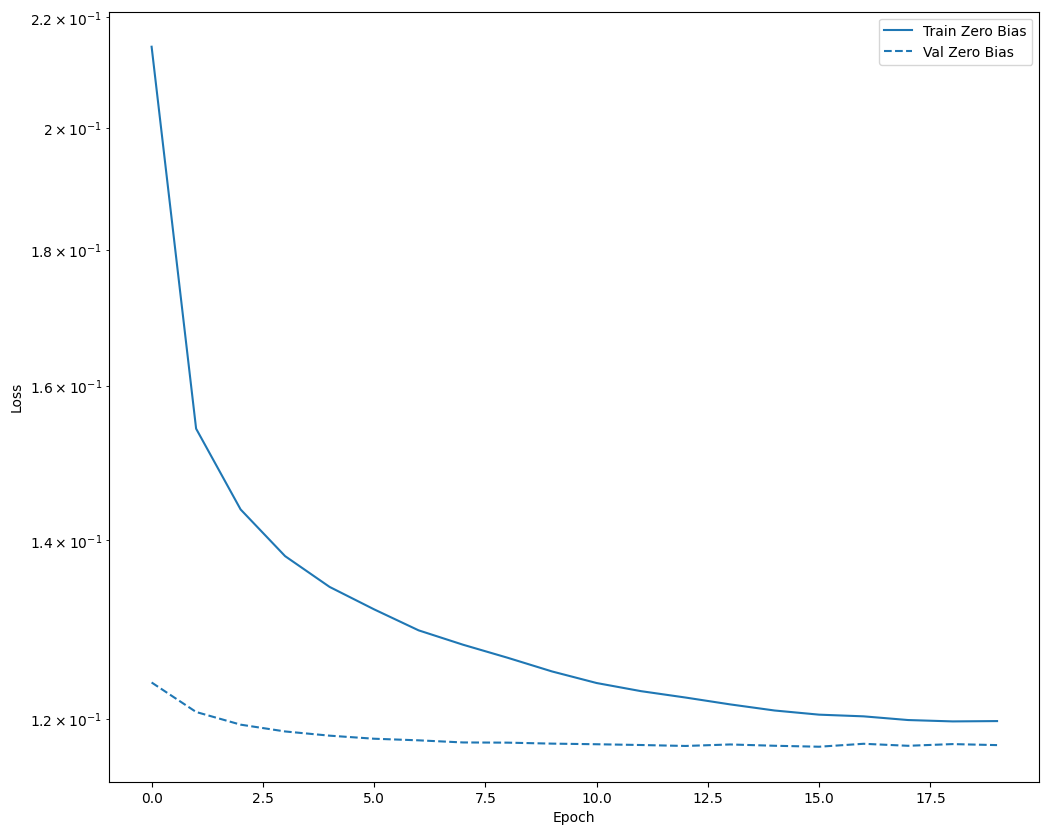

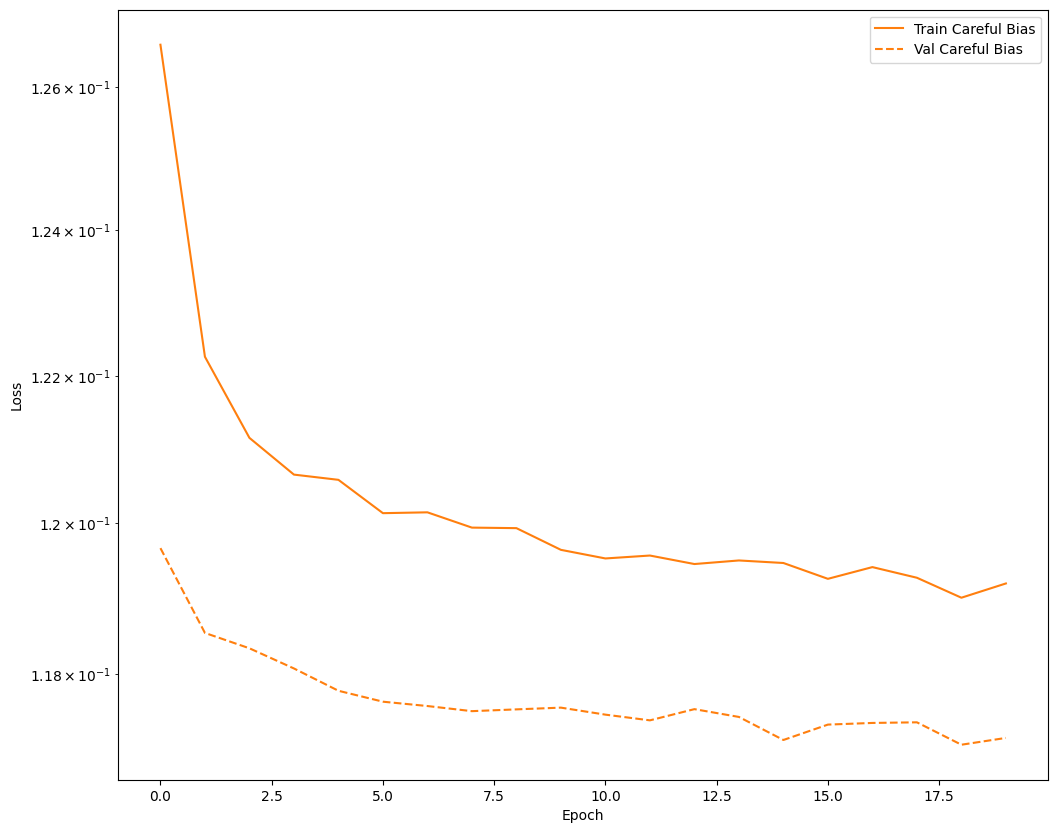







MODEL 5
Epoch 1/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - Brier score: 0.0289 - accuracy: 0.9685 - auc: 0.7939 - cross entropy: 0.1208 - fn: 35916.7070 - fp: 221.2219 - loss: 0.1311 - prc: 0.1266 - precision: 0.3505 - recall: 0.0031 - tn: 1111068.8750 - tp: 114.5882 - val_Brier score: 0.0288 - val_accuracy: 0.9686 - val_auc: 0.8079 - val_cross entropy: 0.1195 - val_fn: 23970.0000 - val_fp: 23.0000 - val_loss: 0.1194 - val_prc: 0.1409 - val_precision: 0.5400 - val_recall: 0.0011 - val_tn: 739310.0000 - val_tp: 27.0000
Epoch 2/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - Brier score: 0.0293 - accuracy: 0.9683 - auc: 0.7881 - cross entropy: 0.1228 - fn: 11963.6787 - fp: 190.5909 - loss: 0.1228 - prc: 0.1167 - precision: 0.3696 - recall: 0.0096 - tn: 371725.0312 - tp: 112.1390 - val_Brier score: 0.0286 - val_accuracy: 0.9686 - val_auc: 0.8122 - val_cross entropy: 0.1185 - val_fn: 23958.0000 - val_fp: 33.0000 - val_loss: 0.1185 - val_prc: 0.1446 - val_precision: 0.5417 - val_r

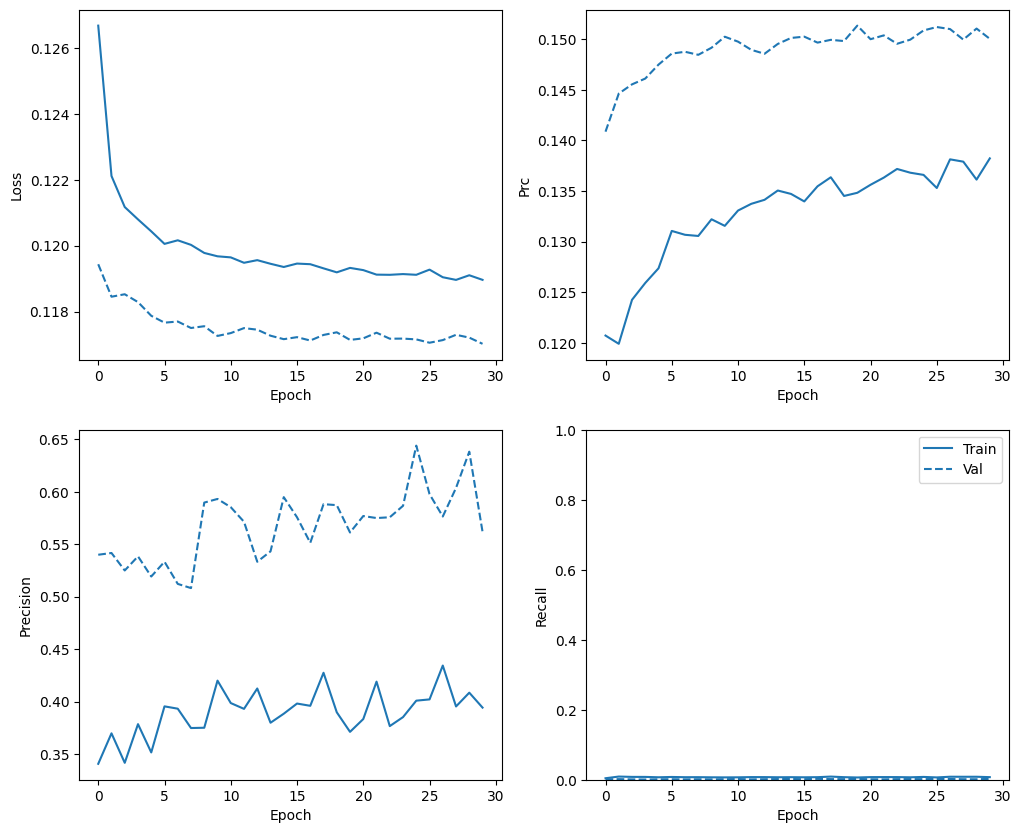

373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
HERE1
loss :  0.11714067310094833
compile_metrics :  0.028489891439676285
HERE2



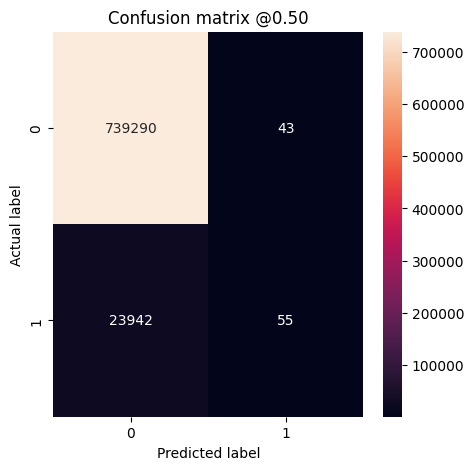

Legitimate Transactions Detected (True Negatives):  739290
Legitimate Transactions Incorrectly Detected (False Positives):  43
Fraudulent Transactions Missed (False Negatives):  23942
Fraudulent Transactions Detected (True Positives):  55
Total Fraudulent Transactions:  23997


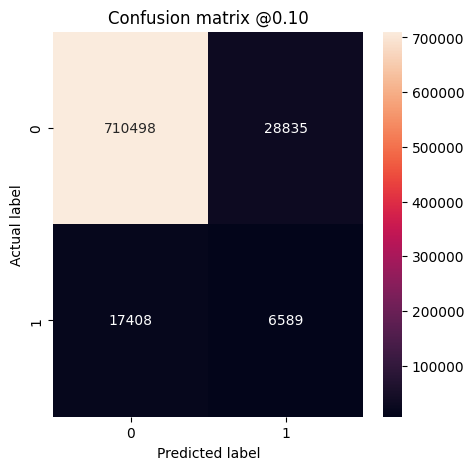

Legitimate Transactions Detected (True Negatives):  710498
Legitimate Transactions Incorrectly Detected (False Positives):  28835
Fraudulent Transactions Missed (False Negatives):  17408
Fraudulent Transactions Detected (True Positives):  6589
Total Fraudulent Transactions:  23997


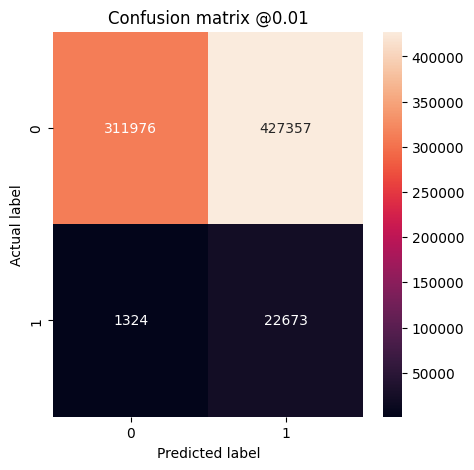

Legitimate Transactions Detected (True Negatives):  311976
Legitimate Transactions Incorrectly Detected (False Positives):  427357
Fraudulent Transactions Missed (False Negatives):  1324
Fraudulent Transactions Detected (True Positives):  22673
Total Fraudulent Transactions:  23997


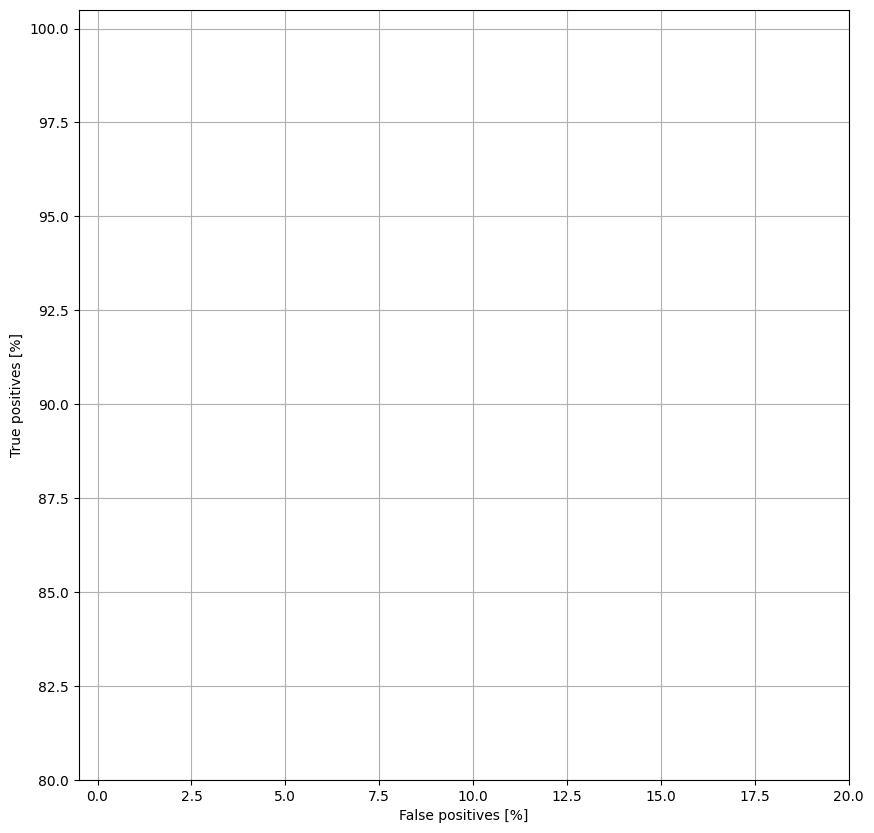

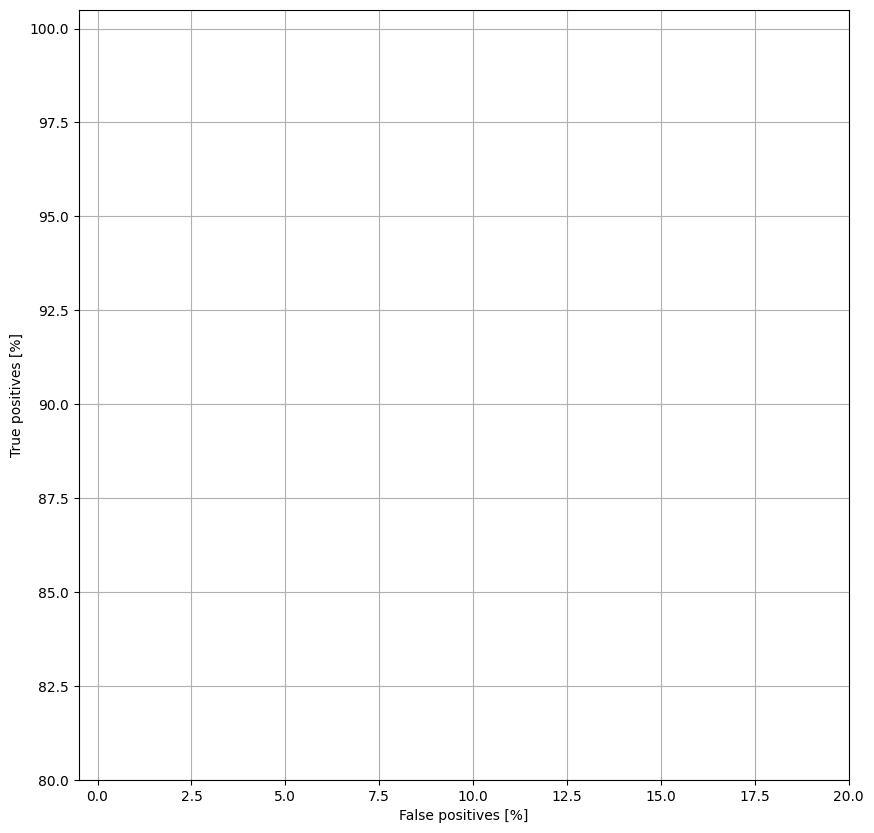







MODEL 6
Weight for class 0: 0.52
Weight for class 1: 16.00


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - Brier score: 0.0625 - accuracy: 0.9209 - auc: 0.7351 - cross entropy: 0.2258 - fn: 31200.6660 - fp: 65644.4141 - loss: 1.0079 - prc: 0.0733 - precision: 0.0795 - recall: 0.1206 - tn: 1045633.1875 - tp: 4843.1953 - val_Brier score: 0.1377 - val_accuracy: 0.8135 - val_auc: 0.8028 - val_cross entropy: 0.4405 - val_fn: 9505.0000 - val_fp: 132837.0000 - val_loss: 0.4404 - val_prc: 0.1286 - val_precision: 0.0984 - val_recall: 0.6039 - val_tn: 606496.0000 - val_tp: 14492.0000
Epoch 2/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - Brier score: 0.1631 - accuracy: 0.7790 - auc: 0.7443 - cross entropy: 0.5437 - fn: 5509.0376 - fp: 78950.1484 - loss: 0.7053 - prc: 0.0951 - precision: 0.0771 - recall: 0.5443 - tn: 292909.0000 - tp: 6623.2515 - val_Brier score: 0.1448 - val_accuracy: 0.7990 - val_auc: 0.8077 - val_cross entropy: 0.4570 - val_fn: 8750.0000 - val_fp: 144678.0000 - val_loss: 0.4569 - val_prc: 0.1331 - val_precision: 0.0953 - val

/tmp/ipykernel_33/81417988.py:260: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,n+1)


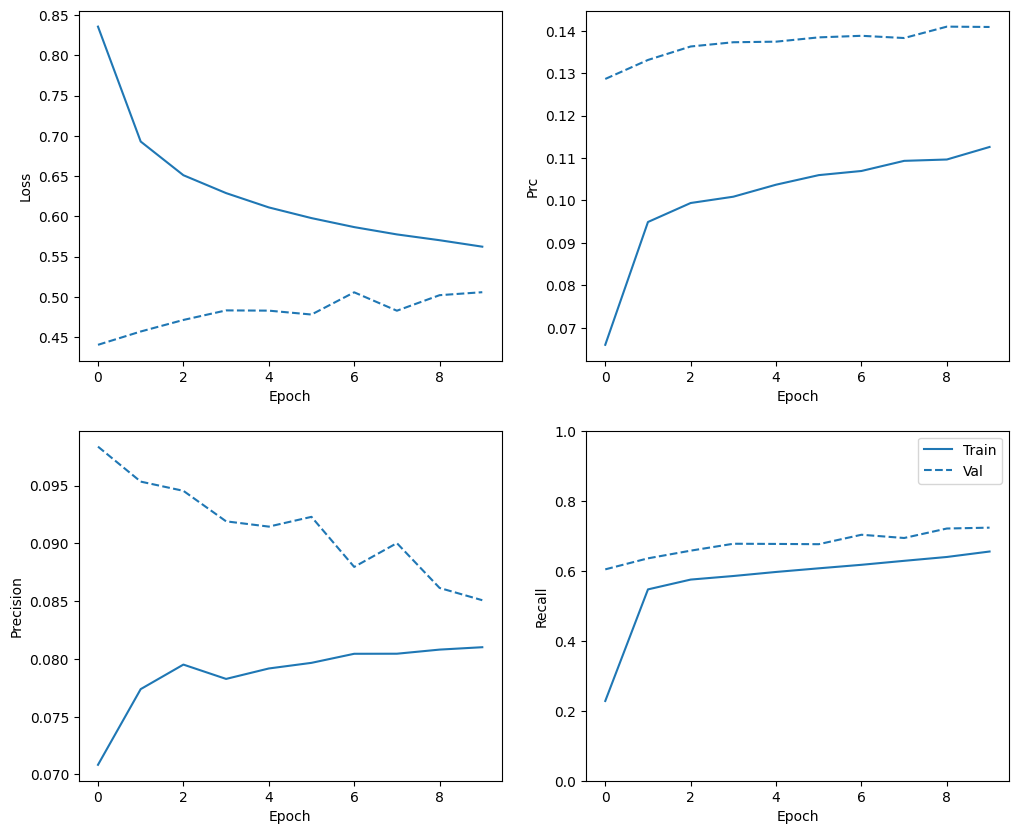

373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
loss :  0.4403574466705322
compile_metrics :  0.13773362338542938



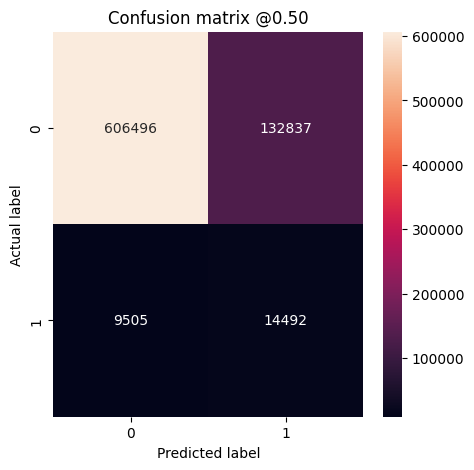

Legitimate Transactions Detected (True Negatives):  606496
Legitimate Transactions Incorrectly Detected (False Positives):  132837
Fraudulent Transactions Missed (False Negatives):  9505
Fraudulent Transactions Detected (True Positives):  14492
Total Fraudulent Transactions:  23997




FINISHED




23855/23855 ━━━━━━━━━━━━━━━━━━━━ 30s 1ms/step
print(probabilities[0:5]) [[0.26259837]
 [0.37912756]
 [0.4913096 ]
 [0.33839658]
 [0.24957429]
 [0.30858368]
 [0.02682566]
 [0.31448162]
 [0.66282004]
 [0.2703431 ]]
oof [0.26259837 0.37912756 0.4913096  0.33839658 0.24957429 0.30858368
 0.02682566 0.31448162 0.66282004 0.2703431 ]
Fold  1 AUC : 0.802841. Elapsed time: 492.96 seconds. Remaining time: 492.96 seconds.
Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too sm

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 16)             │         9,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,889 (38.63 KB)

 Trainable params: 9,889 (38.63 KB)

 Non-trainable params: 0 (0.00 B)

None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Optional: Set the correct initial bias.These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that, see A Recipe for Training Neural Networks: init well. This can help with initial convergence.With the default bias initialization the loss should be about math.log(2) = 0.69314
Loss: 0.6486






MODEL 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Loss: 0.1504






MODEL 3






MODEL 4


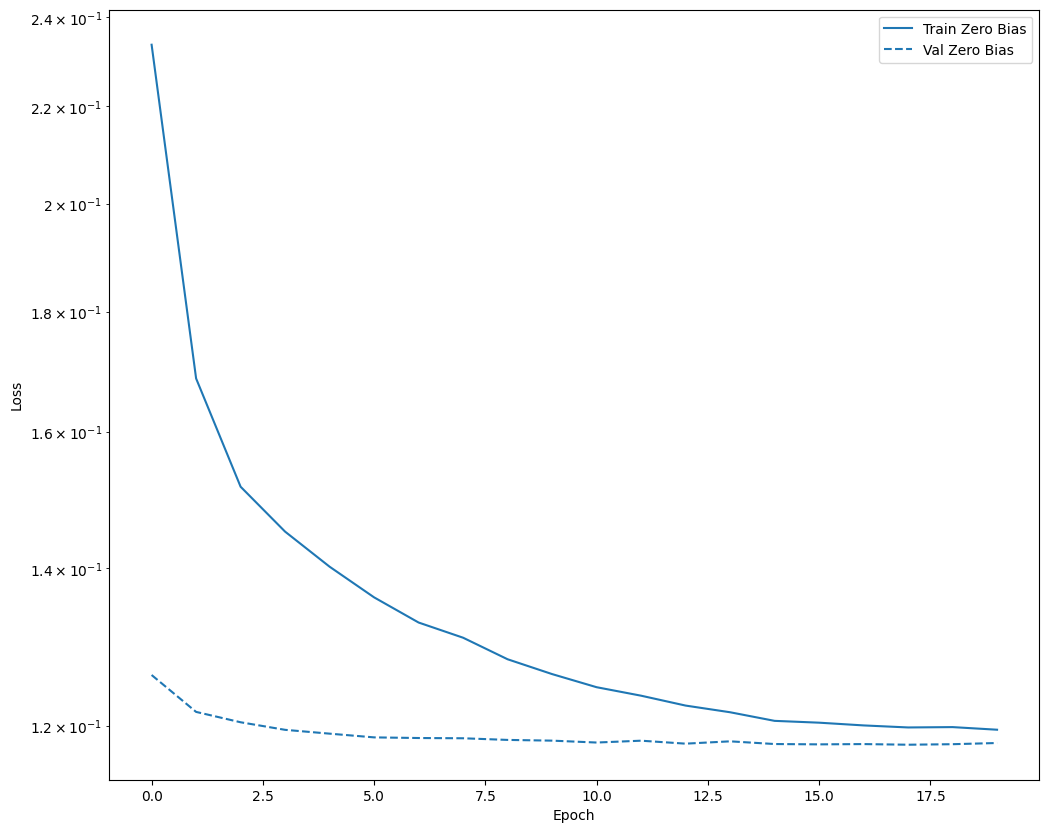

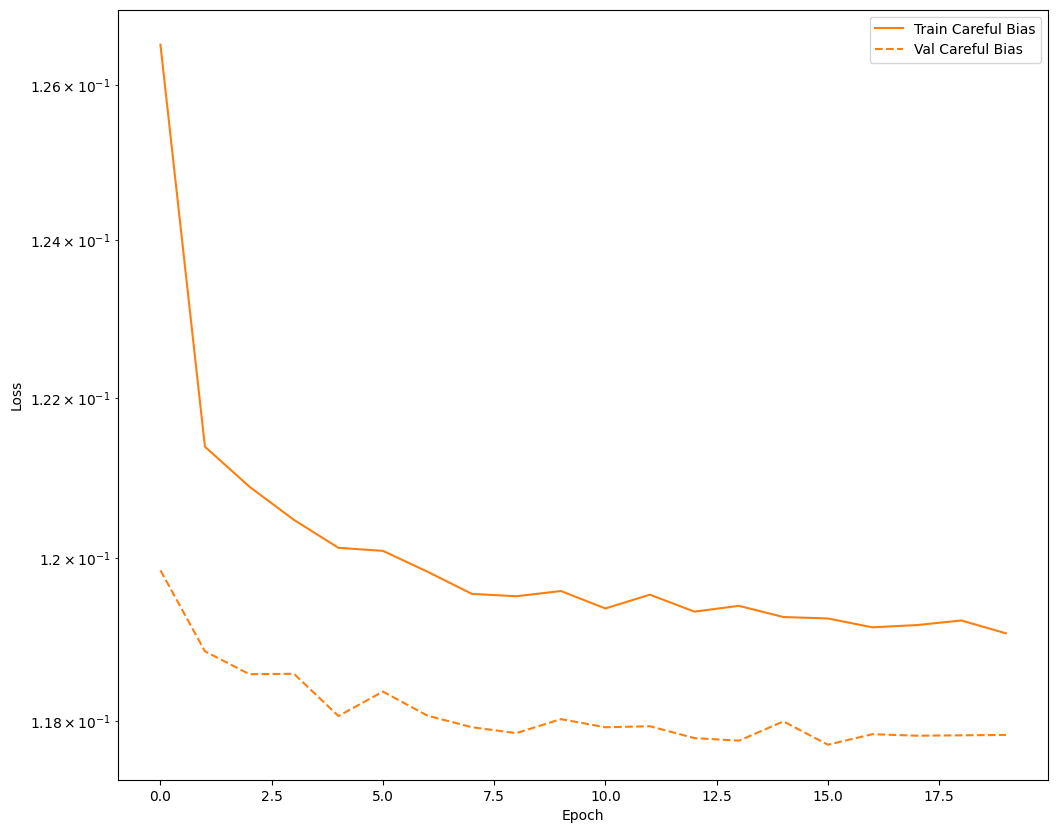







MODEL 5
Epoch 1/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - Brier score: 0.0290 - accuracy: 0.9685 - auc: 0.7904 - cross entropy: 0.1215 - fn: 35913.4297 - fp: 261.7540 - loss: 0.1325 - prc: 0.1234 - precision: 0.3257 - recall: 0.0033 - tn: 1111019.7500 - tp: 125.4759 - val_Brier score: 0.0288 - val_accuracy: 0.9686 - val_auc: 0.8044 - val_cross entropy: 0.1197 - val_fn: 23959.0000 - val_fp: 42.0000 - val_loss: 0.1197 - val_prc: 0.1371 - val_precision: 0.4750 - val_recall: 0.0016 - val_tn: 739290.0000 - val_tp: 38.0000
Epoch 2/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - Brier score: 0.0292 - accuracy: 0.9682 - auc: 0.7903 - cross entropy: 0.1227 - fn: 11954.9785 - fp: 209.7995 - loss: 0.1227 - prc: 0.1249 - precision: 0.3835 - recall: 0.0106 - tn: 371700.4688 - tp: 126.2166 - val_Brier score: 0.0287 - val_accuracy: 0.9686 - val_auc: 0.8094 - val_cross entropy: 0.1187 - val_fn: 23927.0000 - val_fp: 71.0000 - val_loss: 0.1187 - val_prc: 0.1410 - val_precision: 0.4965 - val

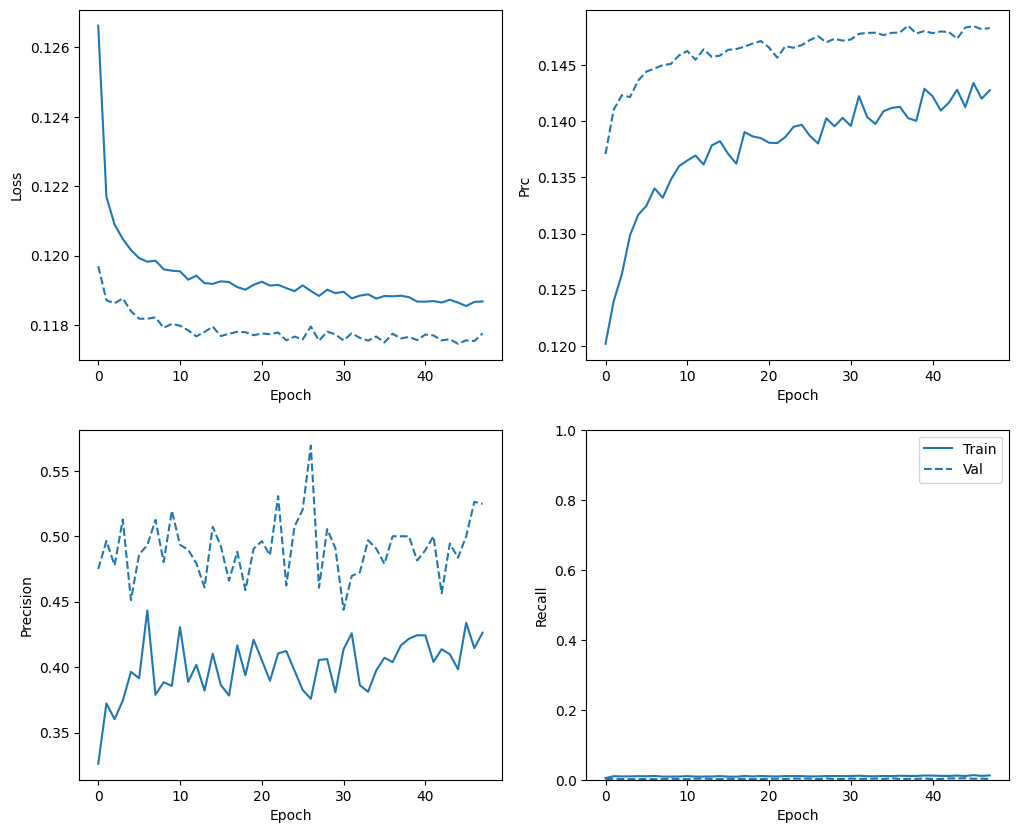

373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
HERE1
loss :  0.11761394888162613
compile_metrics :  0.02854049950838089
HERE2



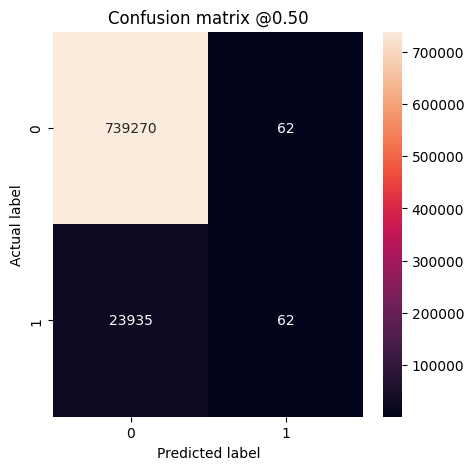

Legitimate Transactions Detected (True Negatives):  739270
Legitimate Transactions Incorrectly Detected (False Positives):  62
Fraudulent Transactions Missed (False Negatives):  23935
Fraudulent Transactions Detected (True Positives):  62
Total Fraudulent Transactions:  23997


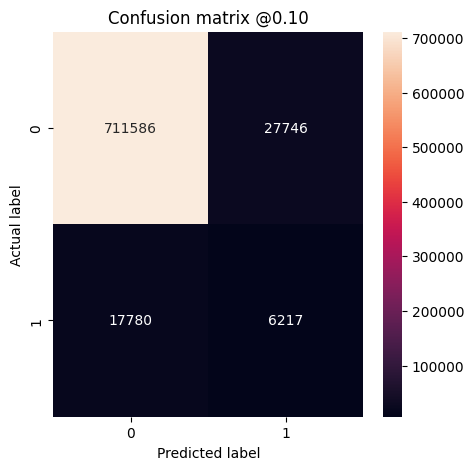

Legitimate Transactions Detected (True Negatives):  711586
Legitimate Transactions Incorrectly Detected (False Positives):  27746
Fraudulent Transactions Missed (False Negatives):  17780
Fraudulent Transactions Detected (True Positives):  6217
Total Fraudulent Transactions:  23997


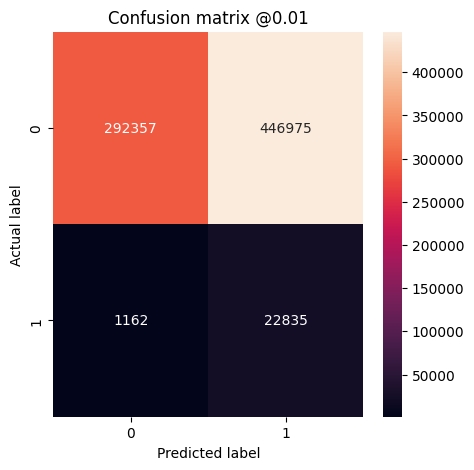

Legitimate Transactions Detected (True Negatives):  292357
Legitimate Transactions Incorrectly Detected (False Positives):  446975
Fraudulent Transactions Missed (False Negatives):  1162
Fraudulent Transactions Detected (True Positives):  22835
Total Fraudulent Transactions:  23997


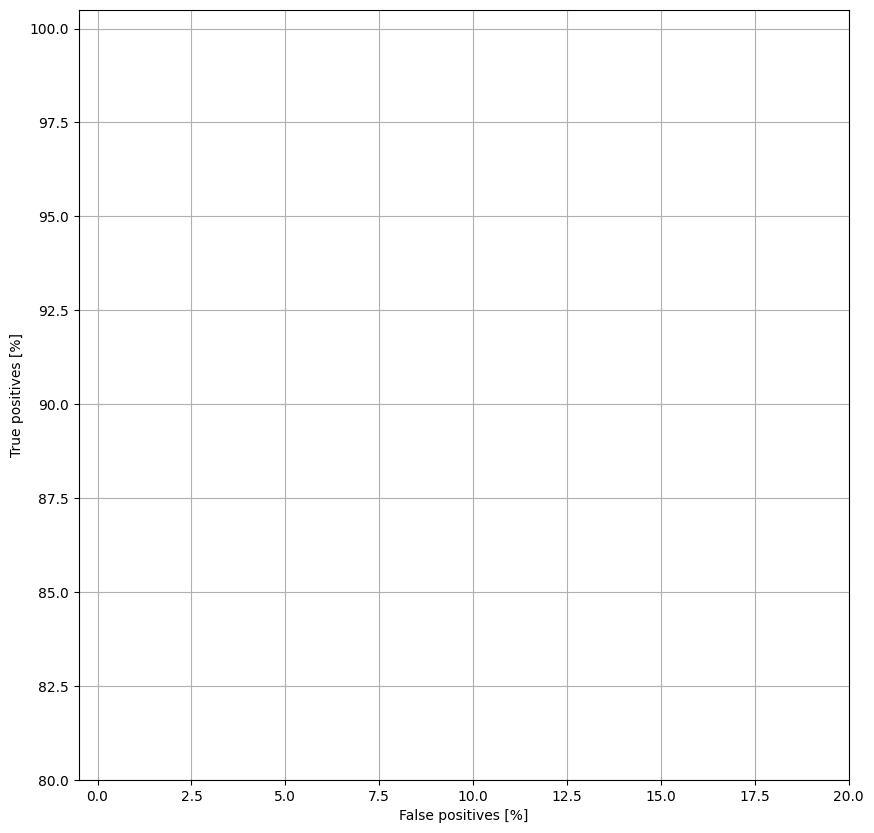

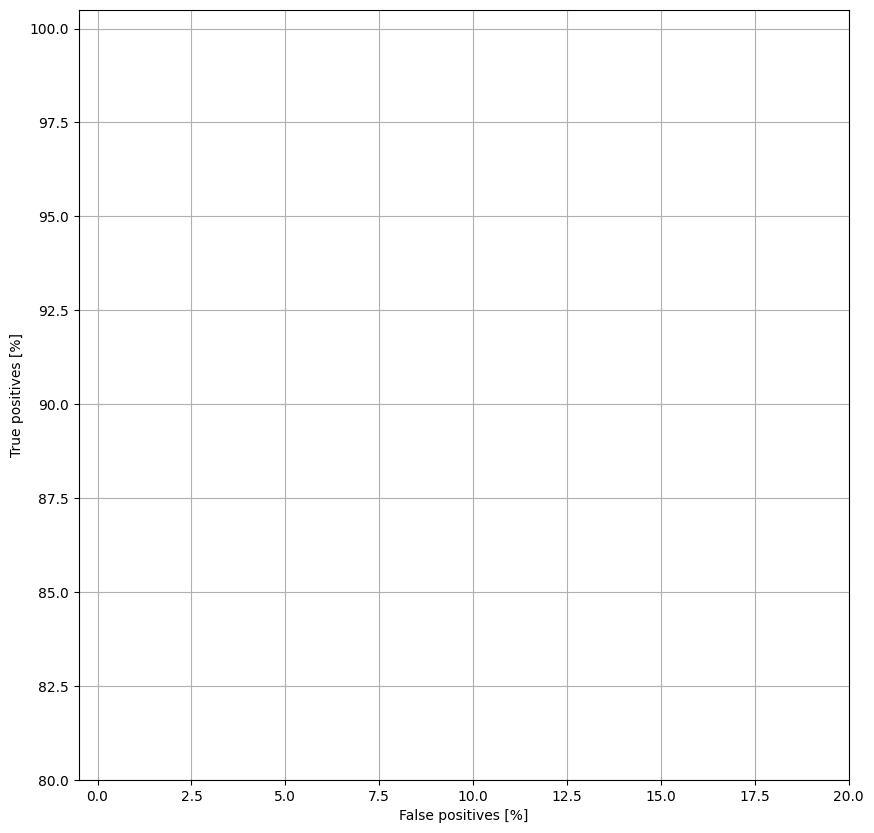







MODEL 6
Weight for class 0: 0.52
Weight for class 1: 16.00


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - Brier score: 0.0628 - accuracy: 0.9206 - auc: 0.7327 - cross entropy: 0.2280 - fn: 30942.0137 - fp: 66077.1875 - loss: 0.9834 - prc: 0.0735 - precision: 0.0846 - recall: 0.1281 - tn: 1045165.2500 - tp: 5135.9868 - val_Brier score: 0.1387 - val_accuracy: 0.8122 - val_auc: 0.8011 - val_cross entropy: 0.4461 - val_fn: 9580.0000 - val_fp: 133749.0000 - val_loss: 0.4460 - val_prc: 0.1291 - val_precision: 0.0973 - val_recall: 0.6008 - val_tn: 605583.0000 - val_tp: 14417.0000
Epoch 2/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - Brier score: 0.1632 - accuracy: 0.7786 - auc: 0.7482 - cross entropy: 0.5427 - fn: 5342.3423 - fp: 79605.7656 - loss: 0.6905 - prc: 0.0967 - precision: 0.0781 - recall: 0.5555 - tn: 292273.4688 - tp: 6769.8745 - val_Brier score: 0.1470 - val_accuracy: 0.7984 - val_auc: 0.8058 - val_cross entropy: 0.4657 - val_fn: 8718.0000 - val_fp: 145192.0000 - val_loss: 0.4655 - val_prc: 0.1331 - val_precision: 0.0952 - val

/tmp/ipykernel_33/81417988.py:260: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,n+1)


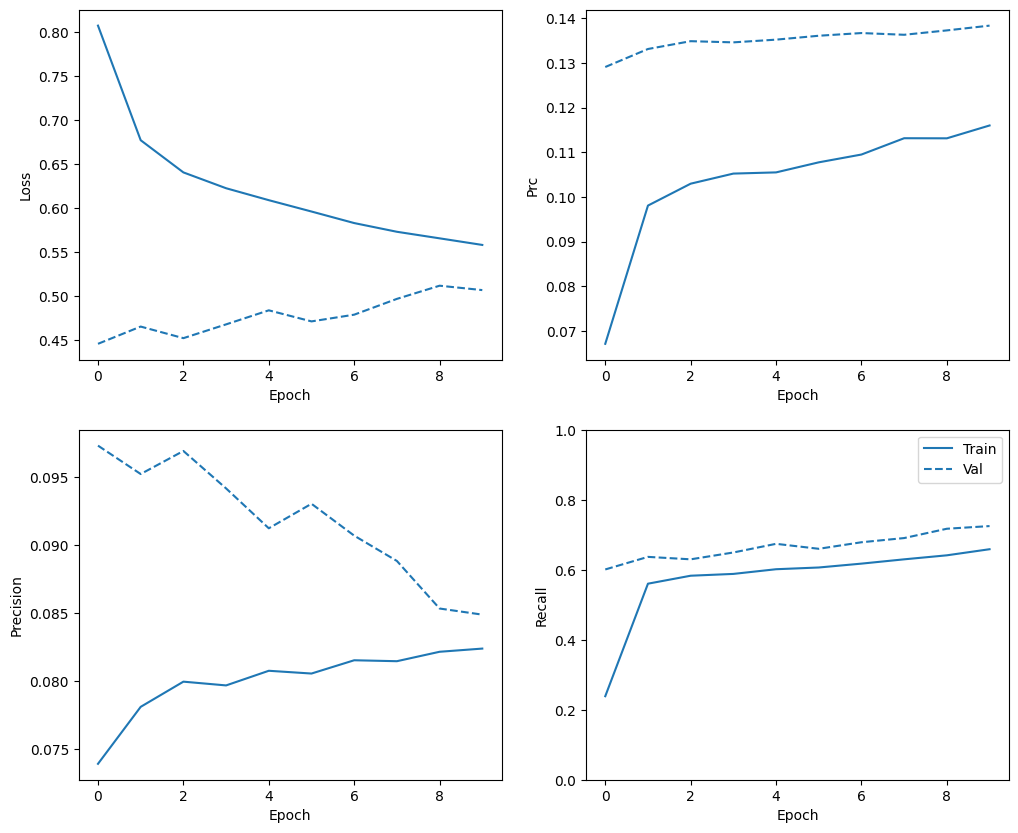

373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
loss :  0.44598084688186646
compile_metrics :  0.1387127786874771



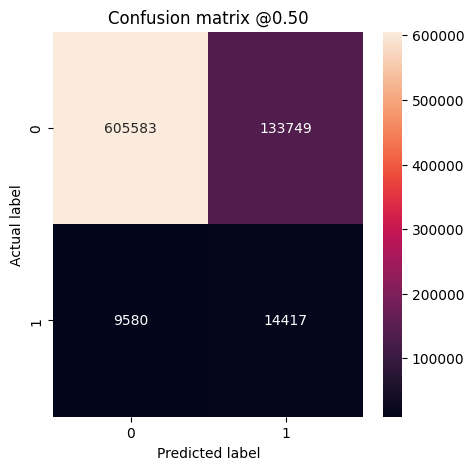

Legitimate Transactions Detected (True Negatives):  605583
Legitimate Transactions Incorrectly Detected (False Positives):  133749
Fraudulent Transactions Missed (False Negatives):  9580
Fraudulent Transactions Detected (True Positives):  14417
Total Fraudulent Transactions:  23997




FINISHED




23855/23855 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step
print(probabilities[0:5]) [[0.18486111]
 [0.40194392]
 [0.69025725]
 [0.29068983]
 [0.51765174]
 [0.07799113]
 [0.36789128]
 [0.15767783]
 [0.1774323 ]
 [0.38060138]]
oof [0.18486111 0.40194392 0.69025725 0.29068983 0.51765174 0.07799113
 0.36789128 0.15767783 0.1774323  0.38060138]
Fold  2 AUC : 0.801128. Elapsed time: 1082.35 seconds. Remaining time: 0.00 seconds.
Full AUC score 0.801965
Gini Score of the valid set: 0.5811020669004311
Model training - done in 1087s


Predicting:   0%|          | 0/2 [00:00<?, ? models/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Submission file has been created.
Submission - done in 9s
NOTEBOOK HAS BEEN SUCCESSFULLY EXECUTED !!!
Pipeline total time - done in 1102s


In [56]:

if __name__ == "__main__":
    pd.set_option('display.max_rows', 60)
    pd.set_option('display.max_columns', 100)
    with timer("Pipeline total time"):
        main(debug= False)